# Initialization of MNIST dataset

In [2]:
import torch
from torchvision import datasets, transforms
from utility.HebbianNetworkClassifier import HebbianNetworkClassifier
import matplotlib.pyplot as plt
import numpy as np
import pickle
import wandb
from utility.transforms import RandomBoxOverlay

# set seed for reproducibility
torch.manual_seed(44)
torch.mps.manual_seed(44)

In [3]:
# Define the transformation to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


transform_train = transforms.Compose([
    transforms.ToTensor(),
    # RandomBoxOverlay(probability=0.5, min_box_size=3, max_box_size=10),
    # transforms.GaussianBlur(3, sigma=(0.1, 1.5)),
    # transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    # transforms.RandomRotation(5),
    transforms.Normalize((0.1307,), (0.3081,))
])

batch_size = 64
# Download and load the MNIST training dataset
trn_dataset = datasets.MNIST(root='./data', train=True, transform=transform_train, download=True)
trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)


# Split the training dataset into training and validation datasets
train_size = int(0.85 * len(trn_dataset))
val_size = len(trn_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trn_dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=True)


# Download and load the MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)


In [4]:
# Print the number of samples in the training and test datasets
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 51000
Number of test samples: 10000


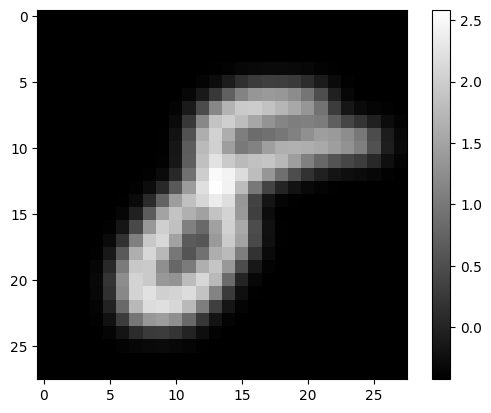

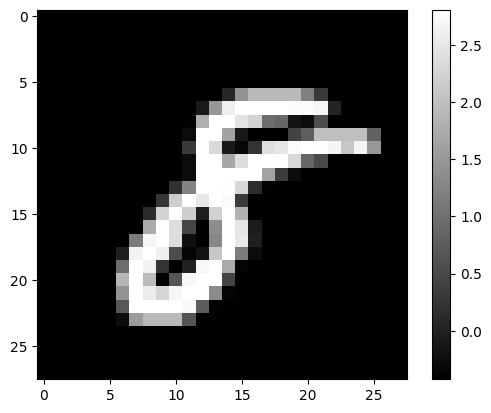

In [5]:
#plot a sample
img = train_dataset[4][0]
gaussian = transforms.GaussianBlur(5, sigma=(1.0, 1.0))
plt.imshow(gaussian(img)[0], cmap='gray')
plt.colorbar()
plt.show()
plt.imshow(img[0], cmap='gray')
plt.colorbar()

## Helper functions for visualization

In [6]:
def print_weights_dist(model):
    """
    Print the distribution of weights for each layer in the model
    """
    # print distribution of weights
    fig, axs = plt.subplots(1, len(model.layers), figsize=(10, 3))

    for i in range(len(model.layers)):
        axs[i].hist(model.layers[i].weight.detach().cpu().numpy().flatten(), bins=100)
        axs[i].set_title(f"Layer {i} weights")

    plt.tight_layout()
    plt.show()

In [7]:
def print_ABCD_dist(model):
    """
    Print the distribution of A, B, C, D and eta for each layer in the model
    """
    num = 6 if model.layers[0].neuron_centric else 4
    if model.layers[0].use_d:
        num += 2 if model.layers[0].neuron_centric else 1

    fig, axs = plt.subplots(num, len(model.layers), figsize=(10, 8))

    for i in range(len(model.layers)):
        if model.layers[i].neuron_centric:
            axs[0, i].hist(model.layers[i].Ai.detach().cpu().numpy(), bins=60)
            axs[0, i].set_title(f"Layer {i} A")

            axs[1, i].hist(model.layers[i].Bj.detach().cpu().numpy(), bins=60)
            axs[1, i].set_title(f"Layer {i} B")

            axs[2, i].hist(model.layers[i].Ci[0].detach().cpu().numpy(), bins=60)
            axs[2, i].set_title(f"Layer {i} Ci")

            axs[3, i].hist(model.layers[i].Cj[0].detach().cpu().numpy(),  bins=60)
            axs[3, i].set_title(f"Layer {i} Cj")

            axs[4, i].hist(model.layers[i].Ei.detach().cpu().numpy().flatten(), bins=60)
            axs[4, i].set_title(f"Layer {i} Ei")

            axs[5, i].hist(model.layers[i].Ej.detach().cpu().numpy().flatten(), bins=60)
            axs[5, i].set_title(f"Layer {i} Ej")

            if model.layers[i].use_d:
                axs[6, i].hist(model.layers[i].Di.detach().cpu().numpy(),  bins=60)
                axs[6, i].set_title(f"Layer {i} Di")

                axs[7, i].hist(model.layers[i].Dj.detach().cpu().numpy(),  bins=60)
                axs[7, i].set_title(f"Layer {i} Dj")

        else:
            axs[0, i].hist(model.layers[i].A_last.detach().cpu().numpy().flatten(), bins=60)
            axs[0, i].set_title(f"Layer {i} A")

            axs[1, i].hist(model.layers[i].B_last.detach().cpu().numpy().flatten(), bins=60)
            axs[1, i].set_title(f"Layer {i} B")

            axs[2, i].hist(model.layers[i].C_last.detach().cpu().numpy().flatten(), bins=60)
            axs[2, i].set_title(f"Layer {i} C")

            axs[3, i].hist(model.layers[i].eta_last.detach().cpu().numpy().flatten(), bins=60)
            axs[3, i].set_title(f"Layer {i} eta")

            if model.layers[i].use_d:
                axs[4, i].hist(model.layers[i].D_last.detach().cpu().numpy().flatten(), bins=60)
                axs[4, i].set_title(f"Layer {i} D")

    plt.tight_layout()
    plt.show()

In [8]:
def visualize_first_layer_weights(weight, max_neurons_per_layer=512):
    """
    Visualize each neuron's weights in the network as small images.
    This function assumes the network is a list of layers where each layer is represented as a 2D tensor.
    Each layer's shape should be (number_of_neurons_in_the_layer, number_of_weights_per_neuron).
    """
    # Calculate the number of neurons in the layer
    num_neurons = min(weight.shape[0], max_neurons_per_layer)
    grid_size = int(np.ceil(np.sqrt(num_neurons)))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
    
    for neuron_idx in range(num_neurons):
        weights = weight[neuron_idx, :]
        size = weights.detach().cpu().numpy().size
        
        # For the first layer, reshape into 28x28 if it matches the input size of 784
        if size == 784:
            image = weights.reshape(28, 28)
        else:
            # For other layers, attempt a square reshaping for visualization, if possible
            
            side_length = int(np.sqrt(size))
            if side_length * side_length == size:
                image = weights.reshape(side_length, side_length)
            else:
                # If the weights cannot be reshaped into a square, use the closest approximation
                rows = int(np.sqrt(size))
                cols = int(np.ceil(size / rows))
                image = weights.reshape(rows, cols)

        ax = axs.flatten()[neuron_idx]
        image = image.cpu().detach()
        ax.imshow(image, cmap='plasma')
        ax.axis('off')
        
    # Hide any unused subplots
    for ax in axs.flatten()[num_neurons:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_full_layer(weighs):
    plt.figure(figsize=(10, 15))
    plt.imshow(weighs.clone().detach().cpu(), cmap='viridis')
    #plt.colorbar()
    plt.tight_layout()
    plt.show()


In [9]:
def plot_val_train_loss(train_loss, val_loss, train_accuracy, val_accuracy):
     """
     Plot the train and validation loss and accuracy
     """
     # plot the results
     fig, axs = plt.subplots(1, 2, figsize=(10, 3))

     # Plot loss
     axs[0].plot(train_loss, label="train")
     axs[0].plot(val_loss, label="val")
     axs[0].legend()
     axs[0].set_title("Loss")

     # Plot accuracy
     axs[1].plot(train_accuracy, label="train")
     axs[1].plot(val_accuracy, label="val")
     axs[1].legend()
     axs[1].set_title("Accuracy")

    # Adjust layout
     plt.tight_layout()
     
     # Show the plots
     plt.show()

def print_confusion_matrix(confusion_matrix):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.matshow(confusion_matrix, cmap="viridis")

    for (i, j), val in np.ndenumerate(confusion_matrix):
         ax.text(j, i, f"{val:.0f}", ha="center", va="center")

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
     
    plt.show()

In [10]:
def printACDE(model): 
    """
    Print the A, B, C, D, eta for the first layer in the model.
    I can do it only for the first layer because is the only one
    that can be reshaped in a 28x28 image, like the input.
    """
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    ax[0].matshow(model.layers[0].Ai.reshape(28, 28).detach().cpu().numpy(), cmap="viridis")
    ax[0].set_title("A")
    ax[0].axis("off")

    
    ax[1].matshow(model.layers[0].Ci.reshape(28, 28).detach().cpu().numpy(), cmap="viridis")
    ax[1].set_title(f"C_i")
    ax[1].axis("off")

    ax[2].matshow(model.layers[0].etai.reshape(28, 28).detach().cpu().numpy(), cmap="viridis")
    ax[2].set_title("eta")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

# Training Neuro-Centric model

## Training with backprop the hebbian rules

In [11]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model_size = [784, 10]
model = HebbianNetworkClassifier(
    model_size, 
    device=device, 
    # dropout=0.2,
    activation=torch.functional.F.relu,
    neuron_centric=True,
    use_d=True,
    init='linear',
    use_tatgets=False
)

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

Training:   0%|          | 0/3 [00:00<?, ?epoch/s]

Test: 100%|██████████| 20/20 [00:03<00:00,  6.65batch/s, Loss=0.68] 


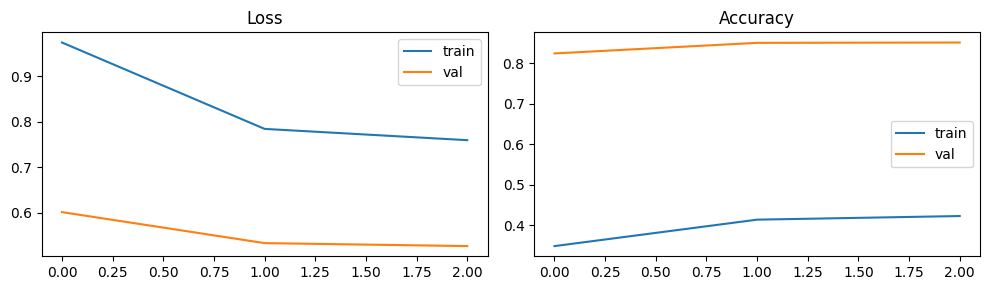

Test accuracy: 0.8655847886029411
Test loss: 0.0001250812564702595


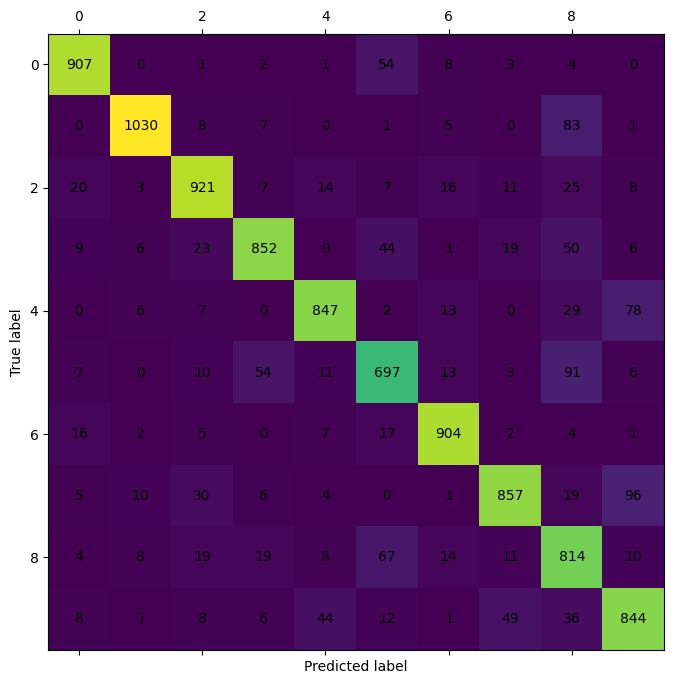

In [12]:
train = True

if train:
     # train the model with backprop
     train_loss, val_loss, test_loss, train_accuracy, val_accuracy, test_accuracy, confusion_matrix = model.train_loop(
          optimizer, loss_fn, train_loader, val_loader, test_loader, epochs=3, log=False, reset_every=1
     )
     # save the model   
     torch.save(model.state_dict(), "hebbian_mnist_neurocentric.pt")

     plot_val_train_loss(train_loss, val_loss, train_accuracy, val_accuracy)

     # print the test results
     print(f"Test accuracy: {test_accuracy}")
     print(f"Test loss: {test_loss}")
     print_confusion_matrix(confusion_matrix)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

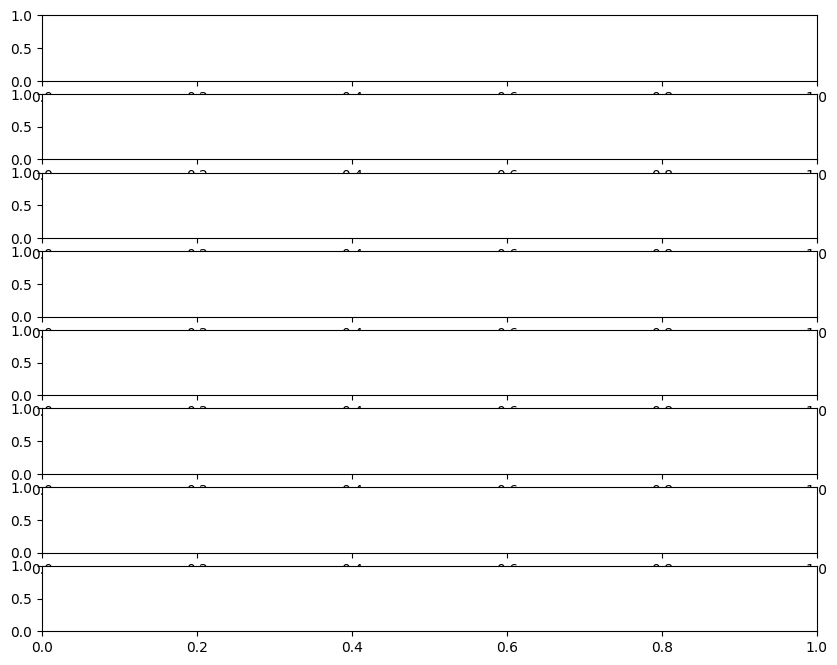

In [13]:
print_ABCD_dist(model)

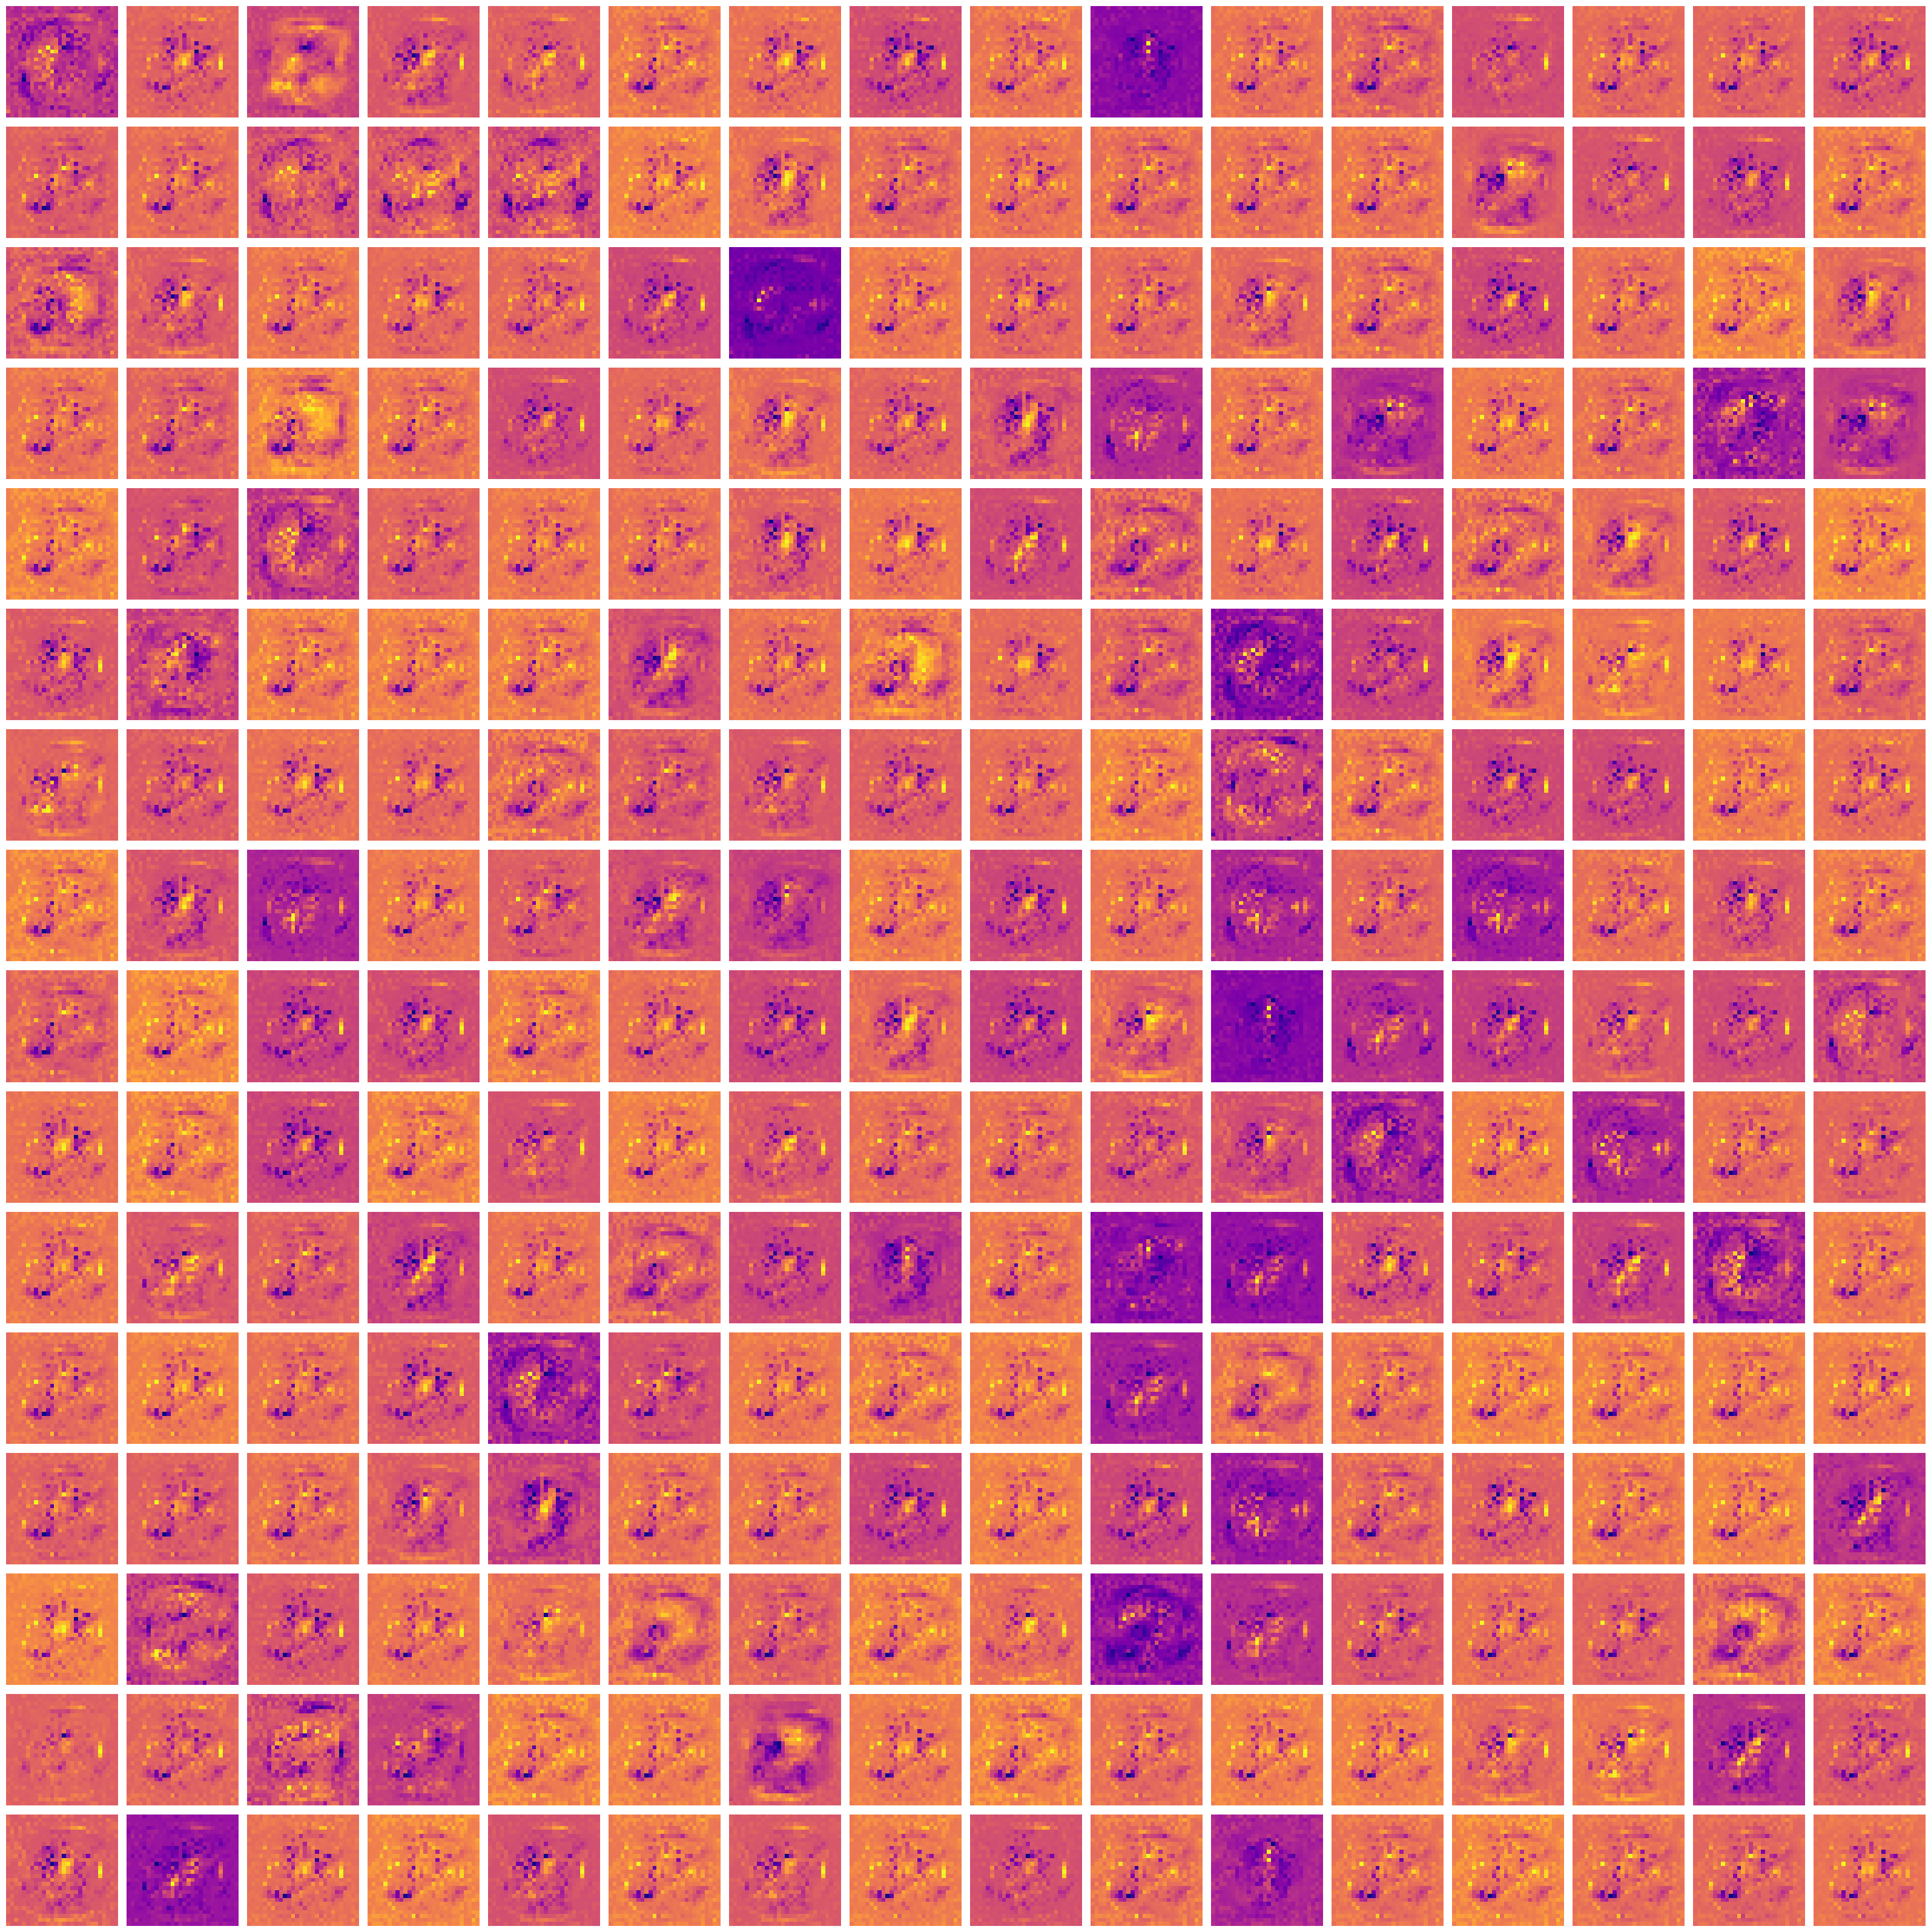

tensor(0.1485, device='mps:0')
tensor(-0.1533, device='mps:0')


In [ ]:
visualize_first_layer_weights(model.layers[0].weight)
print(model.layers[0].weight[0].max())
print(model.layers[0].weight[0].min())

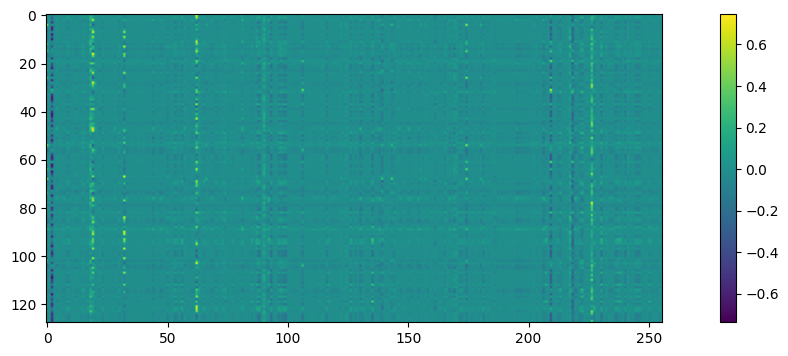

In [ ]:
# print second layer weights
plt.figure(figsize=(15, 4))
plt.imshow(model.layers[1].weight.detach().cpu().numpy(), cmap='viridis')
plt.colorbar()

torch.Size([784, 256])


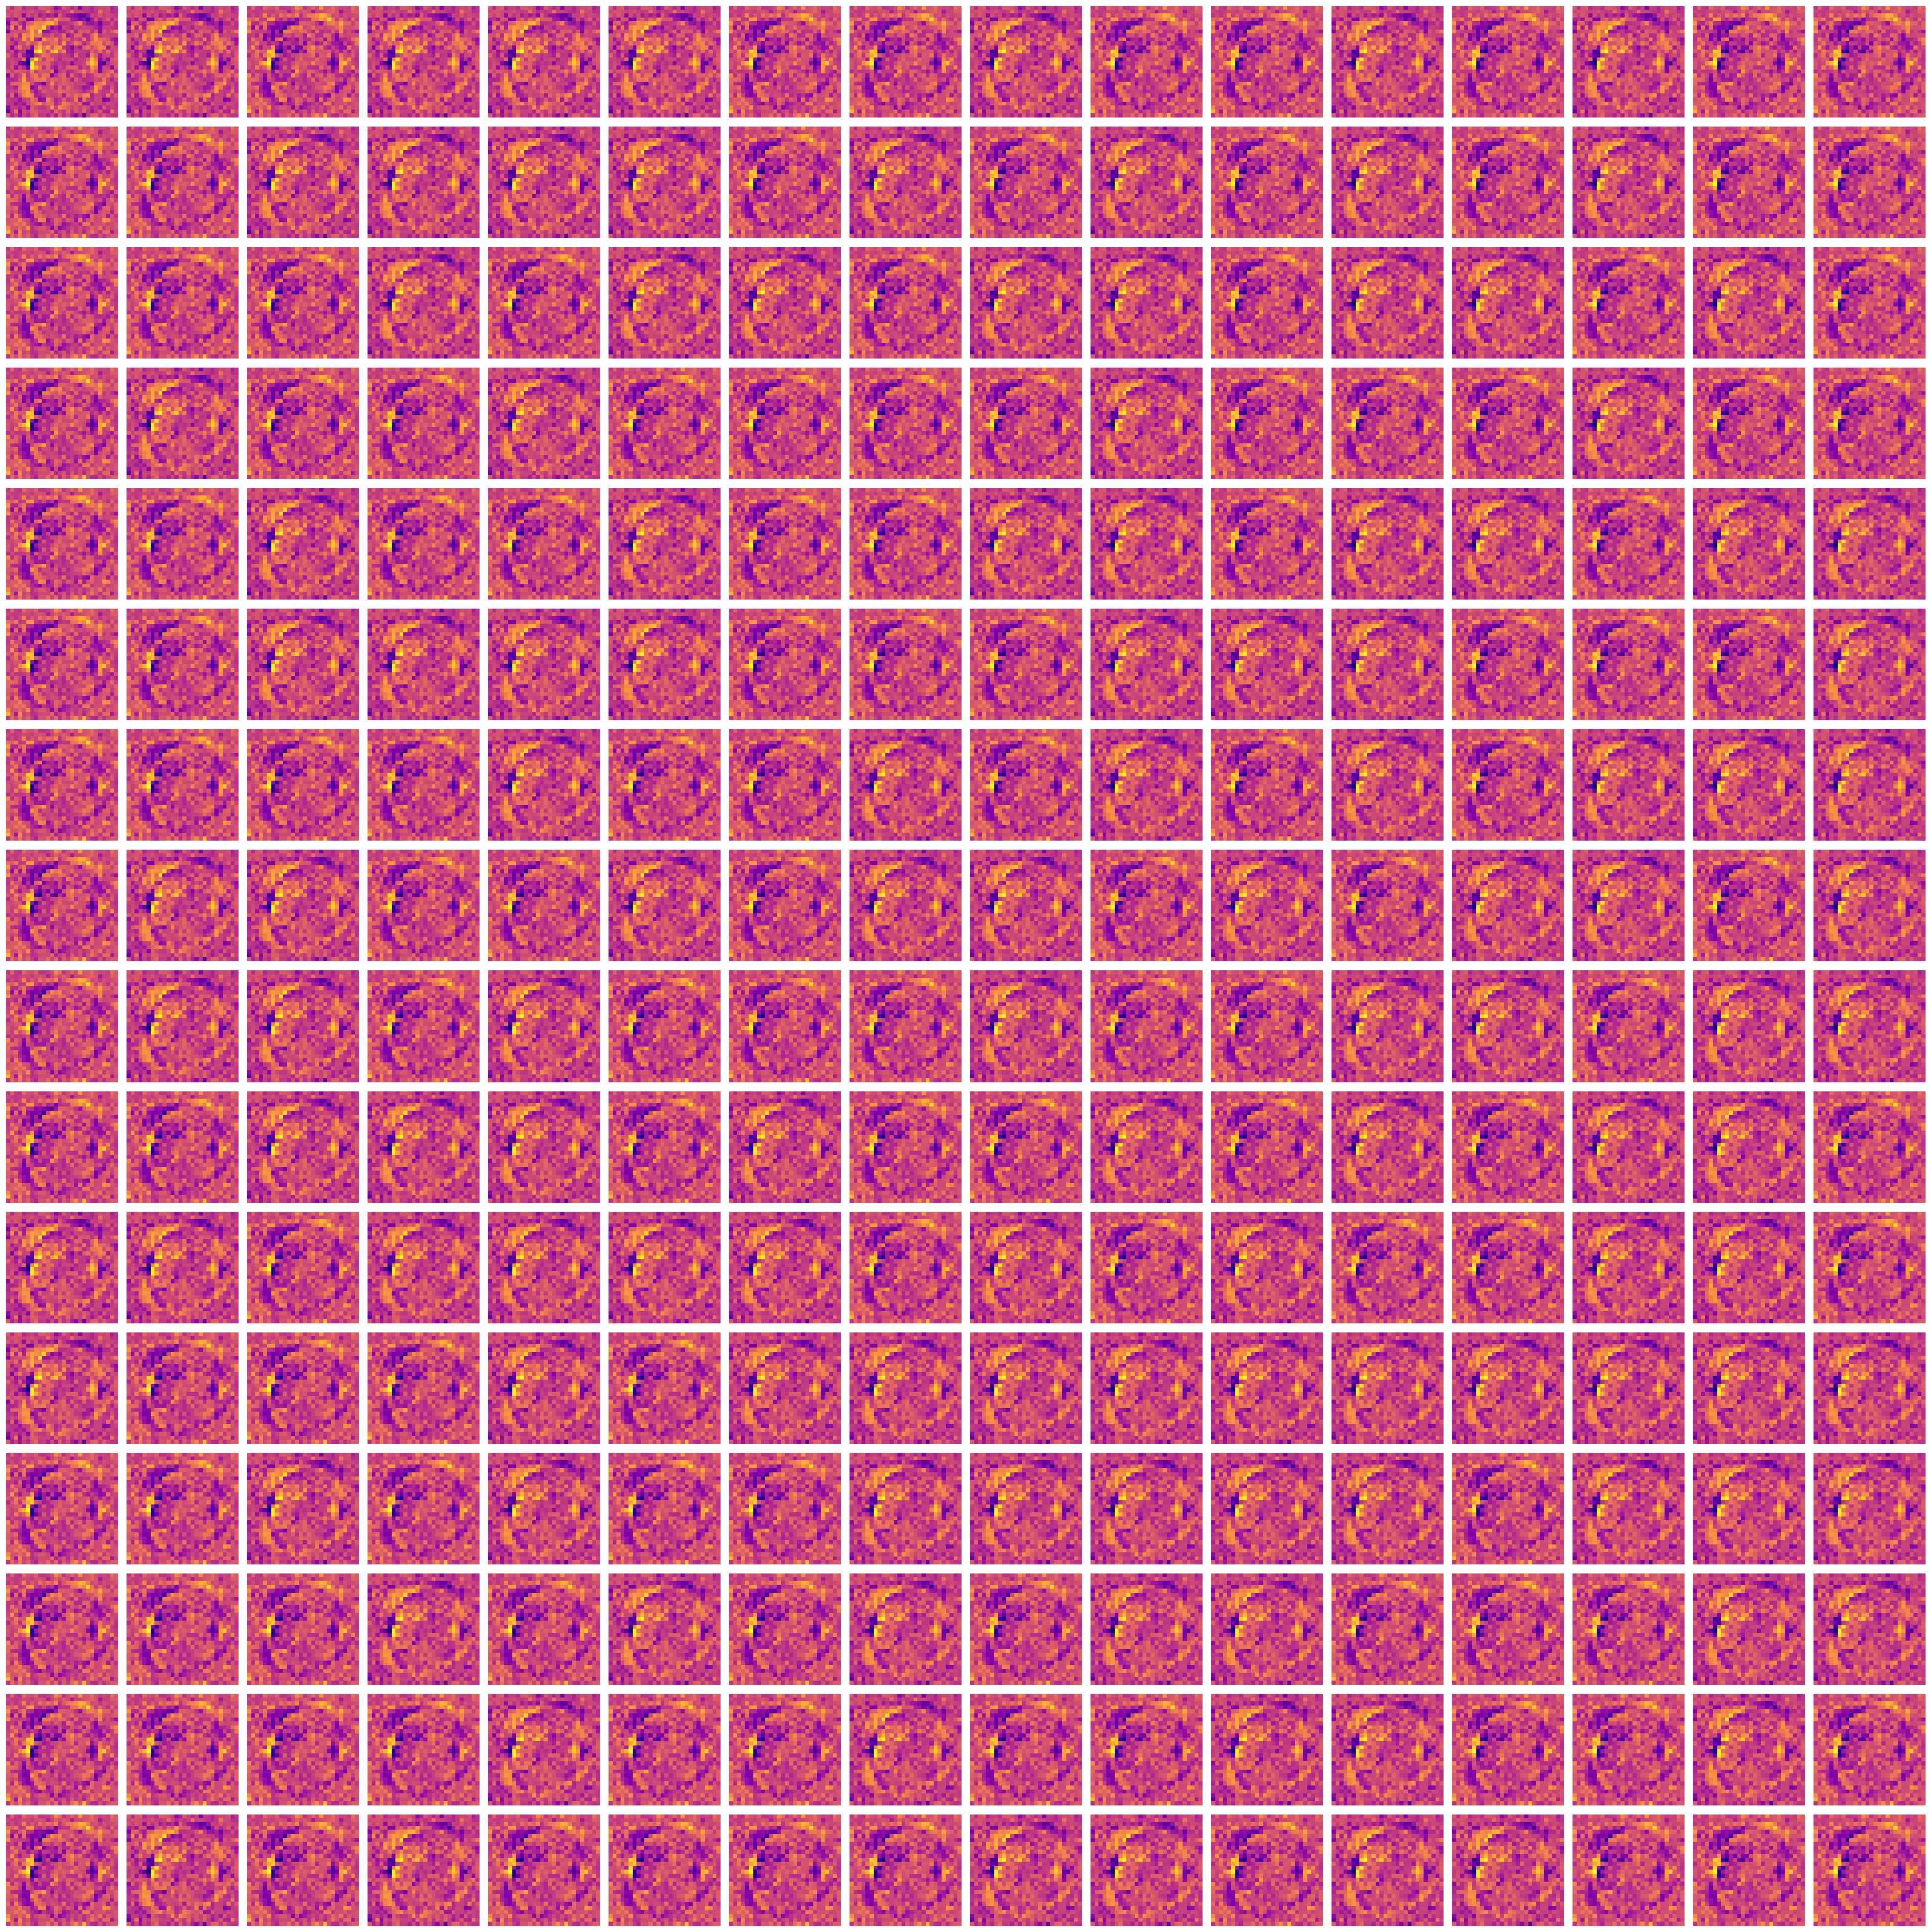

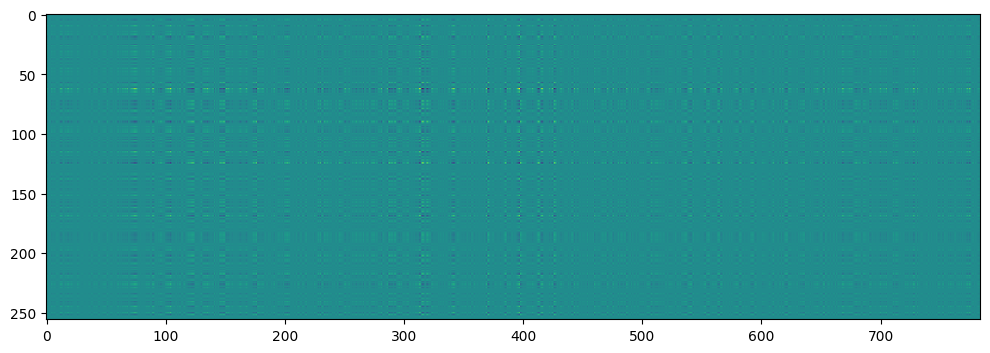

In [ ]:
CiCj = model.layers[0].Ci[0].unsqueeze(-1) * model.layers[0].Cj[0].unsqueeze(0)
print(CiCj.shape)
visualize_first_layer_weights(CiCj.T)
visualize_full_layer(CiCj.T)

torch.Size([784, 256])


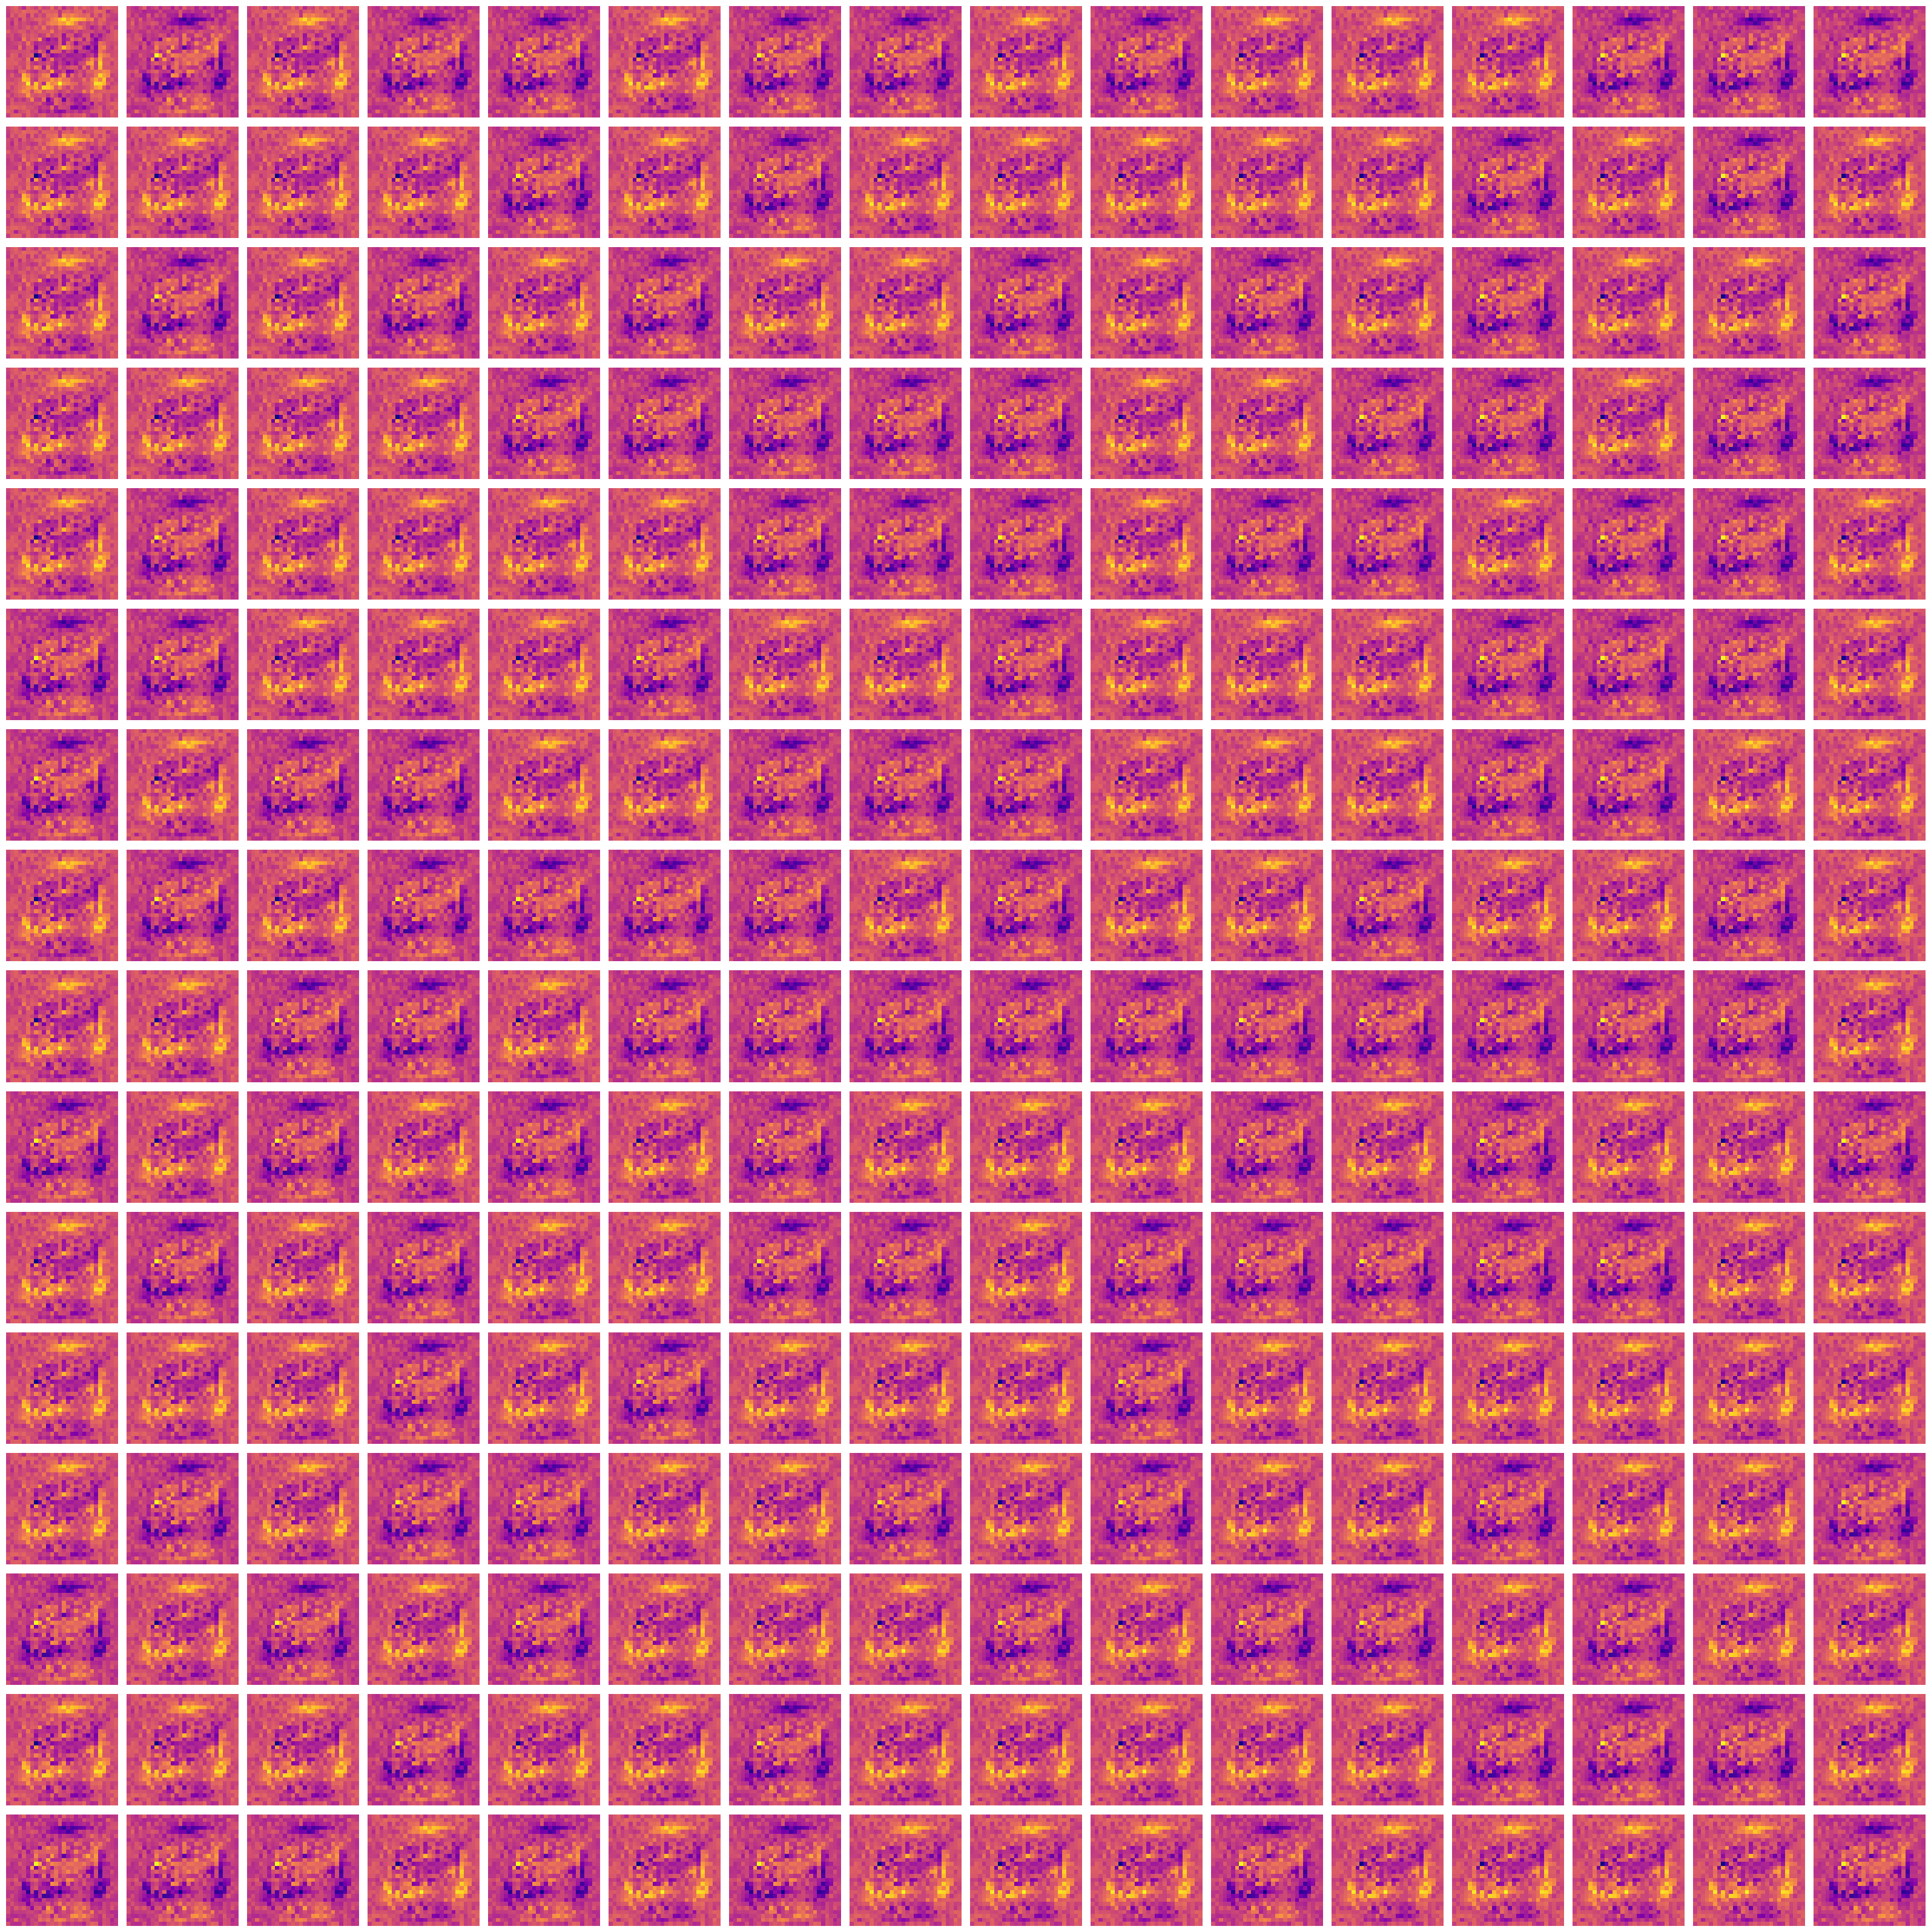

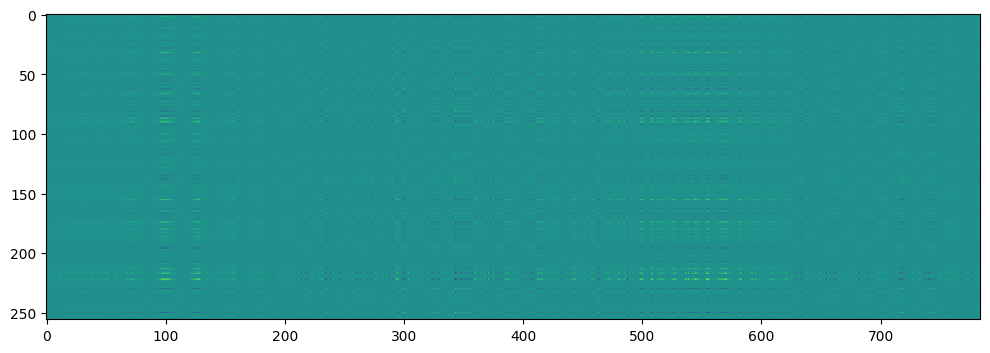

In [ ]:
EiEj = model.layers[0].Ei.unsqueeze(-1) * model.layers[0].Ej.unsqueeze(0)
print(EiEj.shape)
visualize_first_layer_weights(EiEj.T)
visualize_full_layer(EiEj.T)

torch.Size([784, 256])


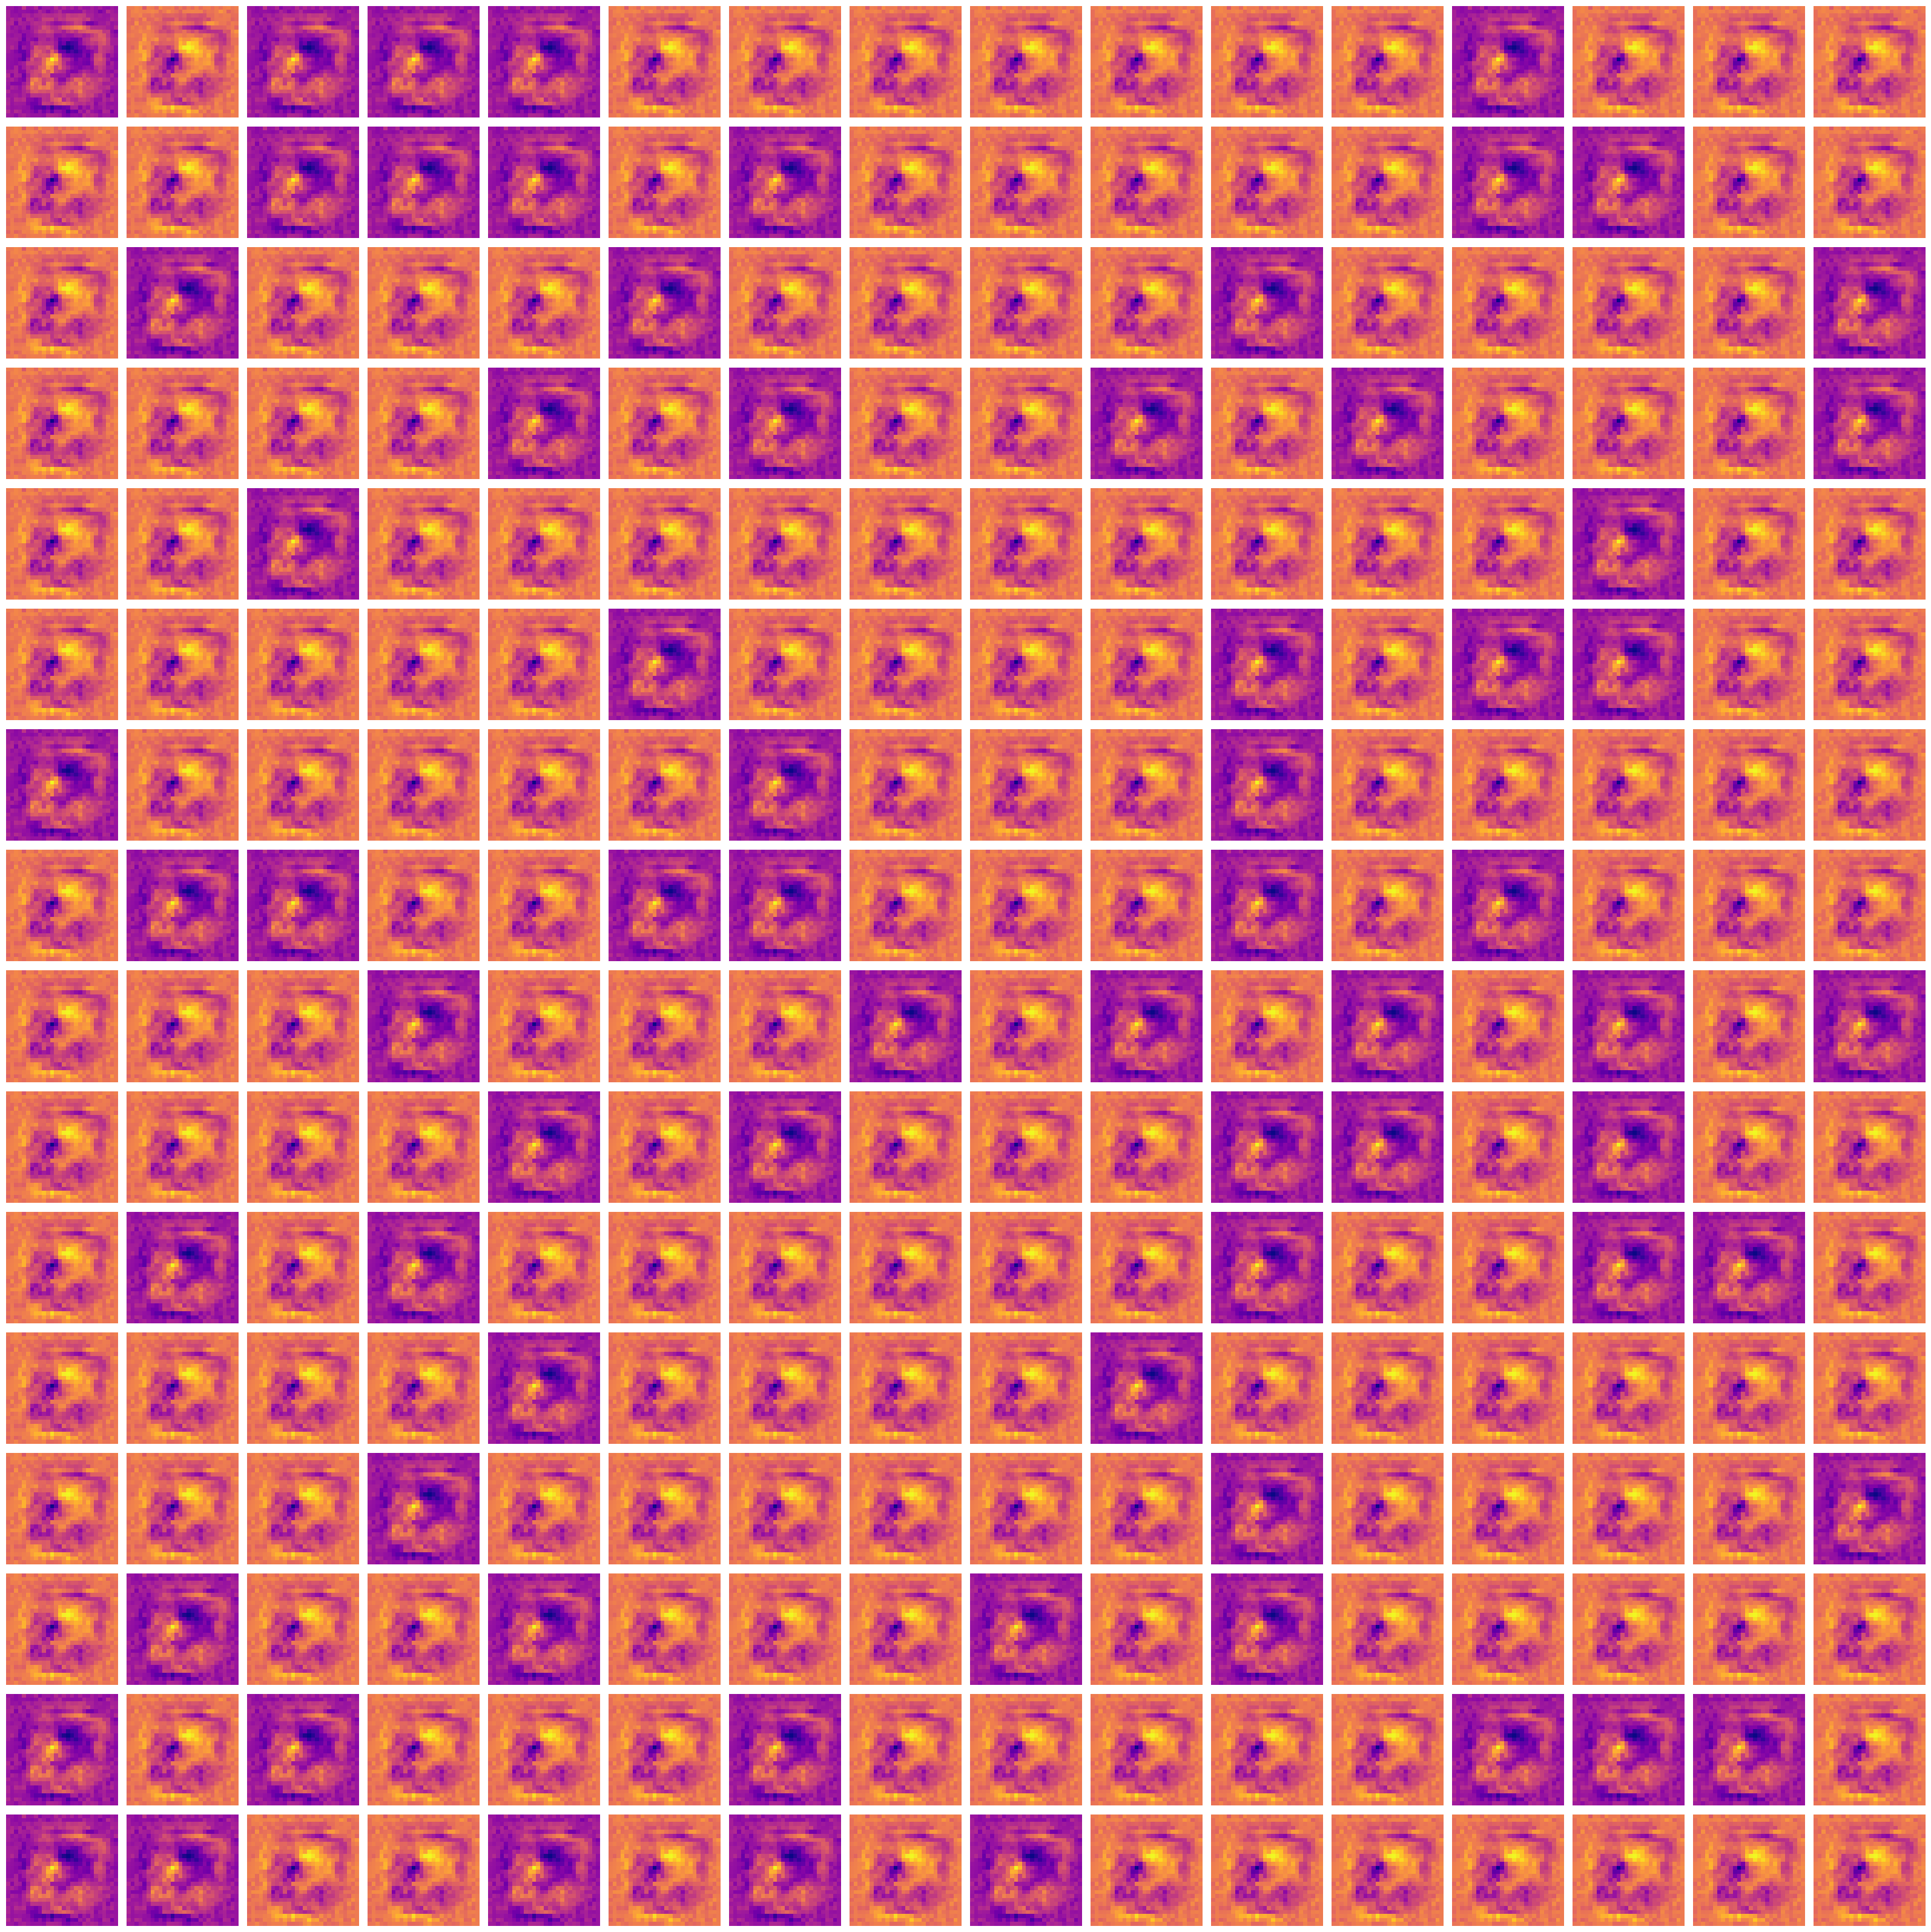

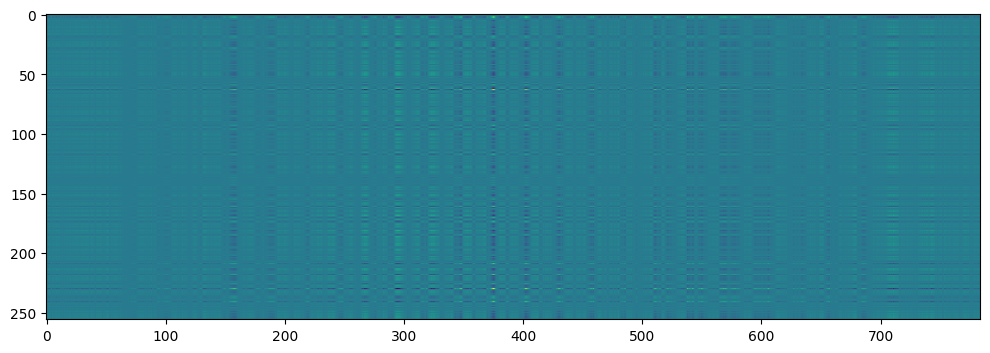

In [ ]:
DiDj = model.layers[0].Di.unsqueeze(-1) * model.layers[0].Dj.unsqueeze(0)
print(DiDj.shape)
visualize_first_layer_weights(DiDj.T)
visualize_full_layer(DiDj.T)

torch.Size([784, 256])


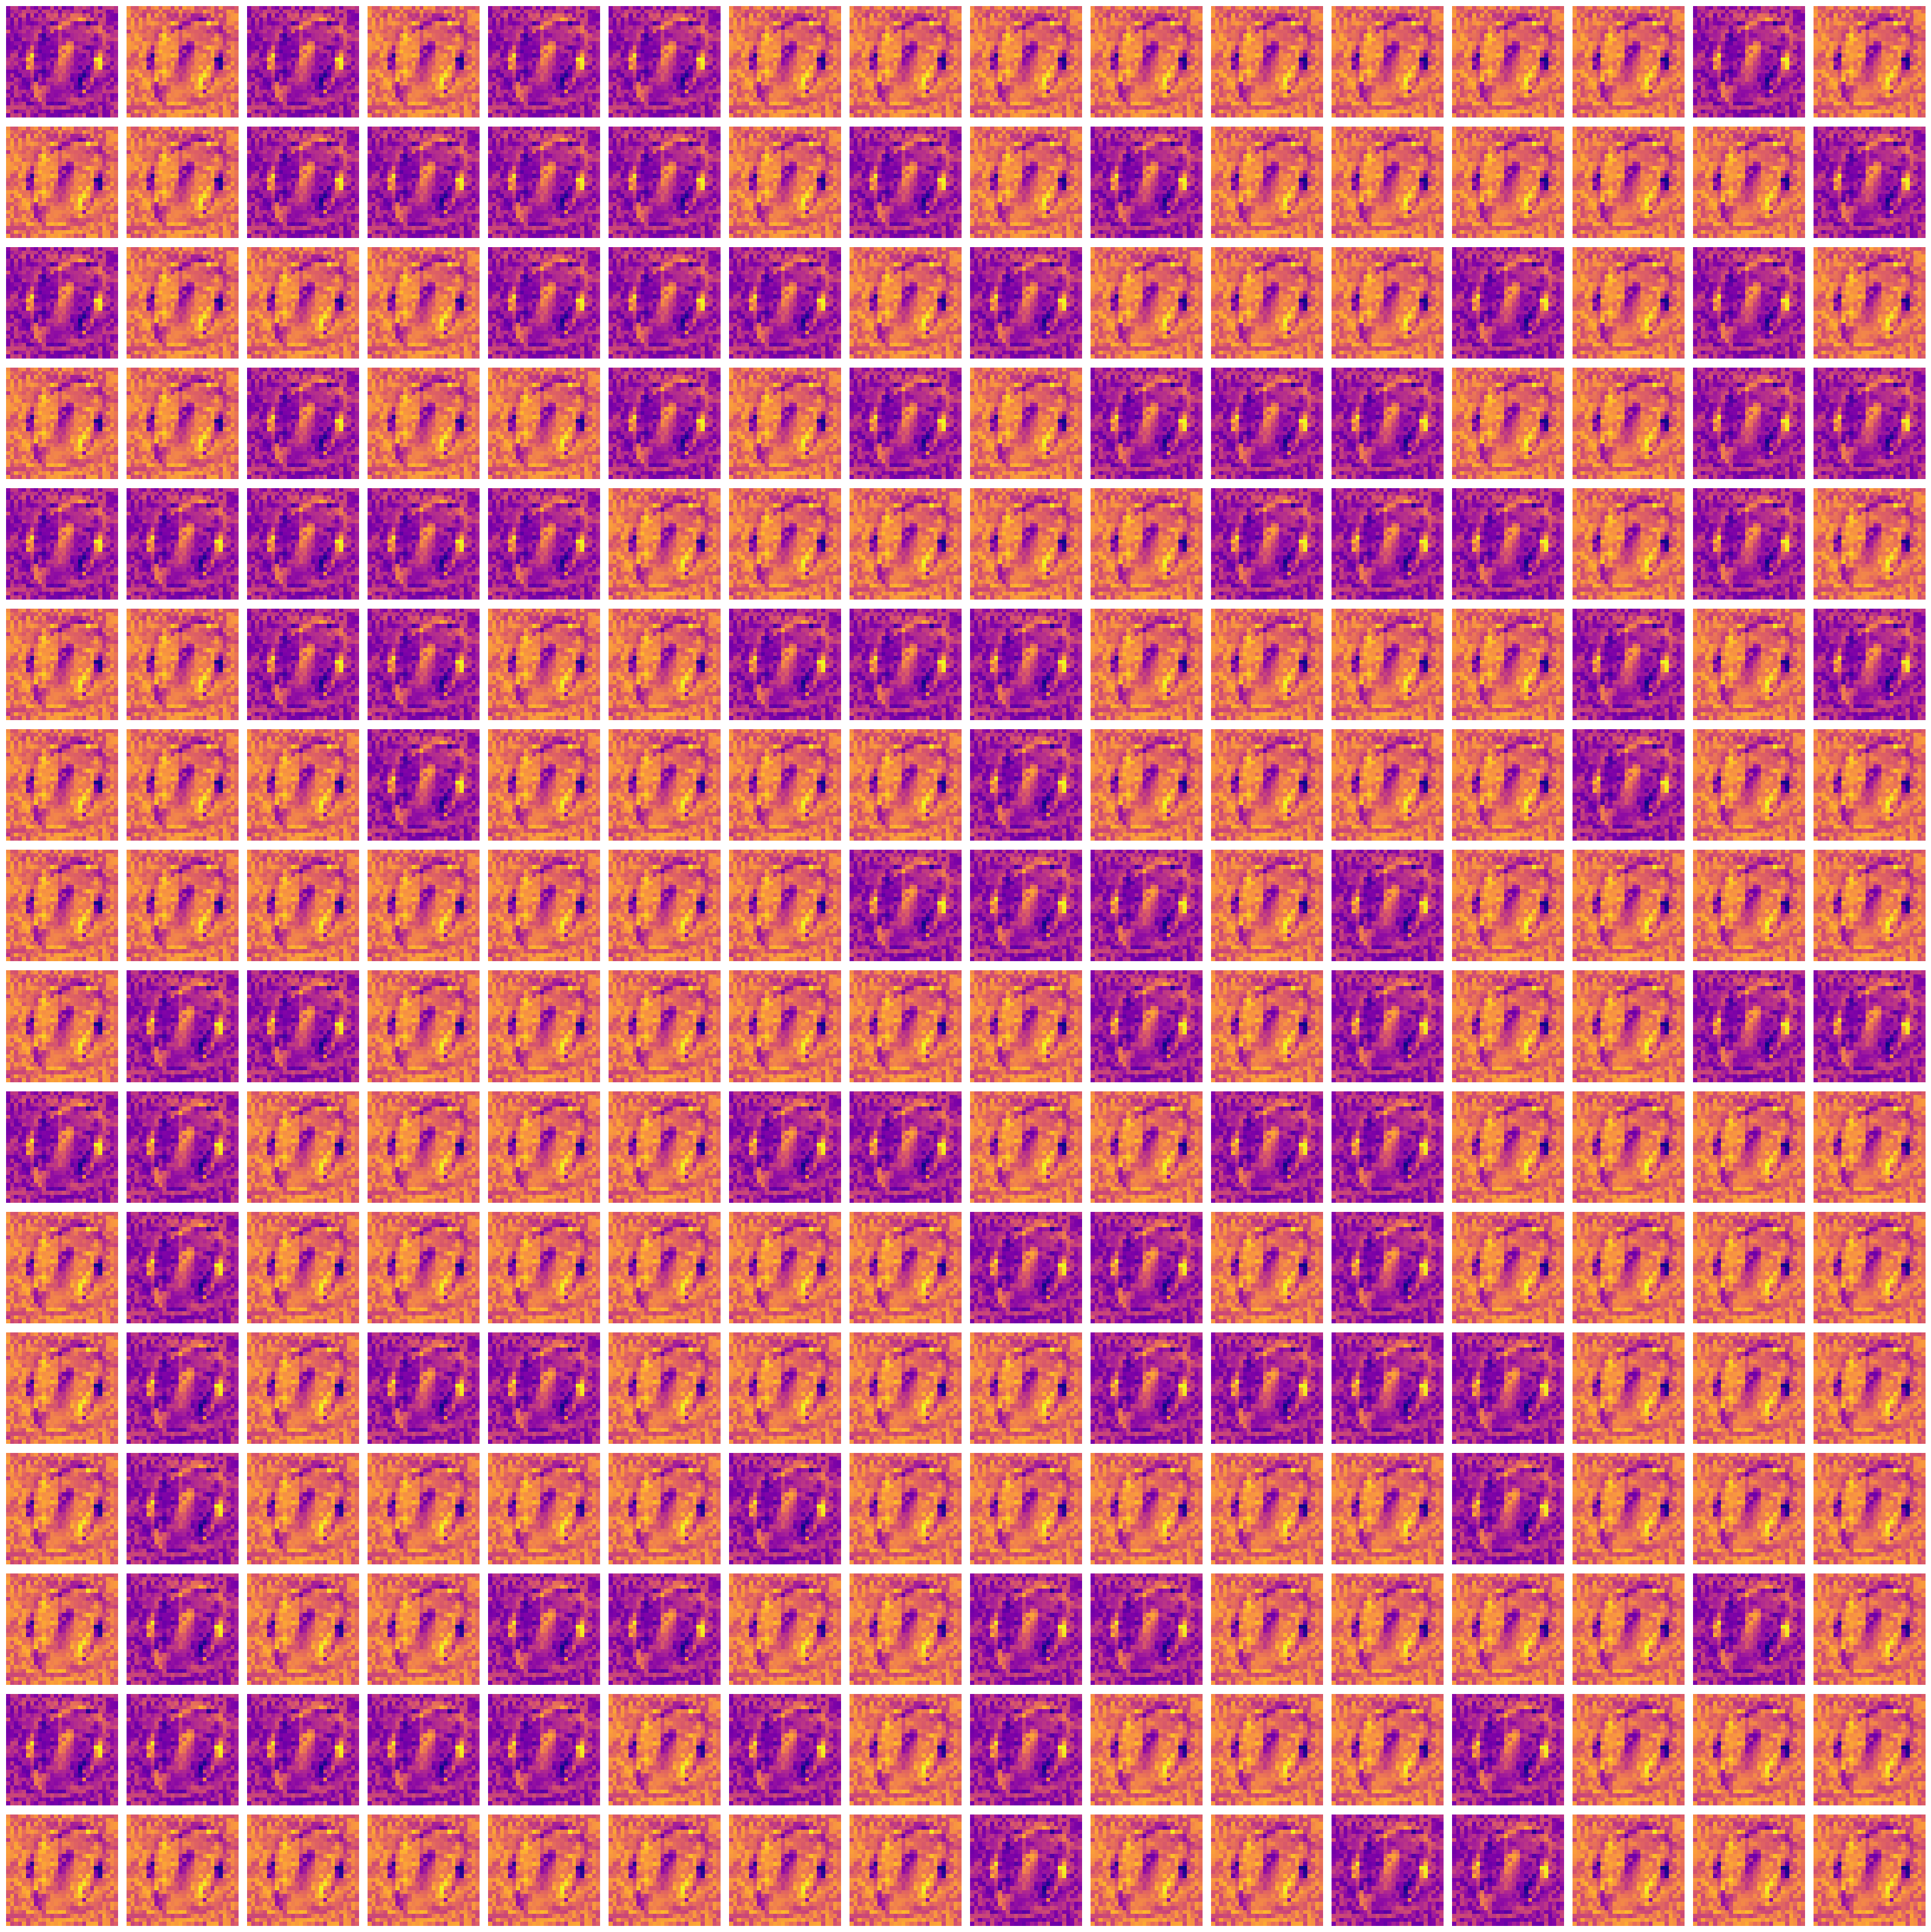

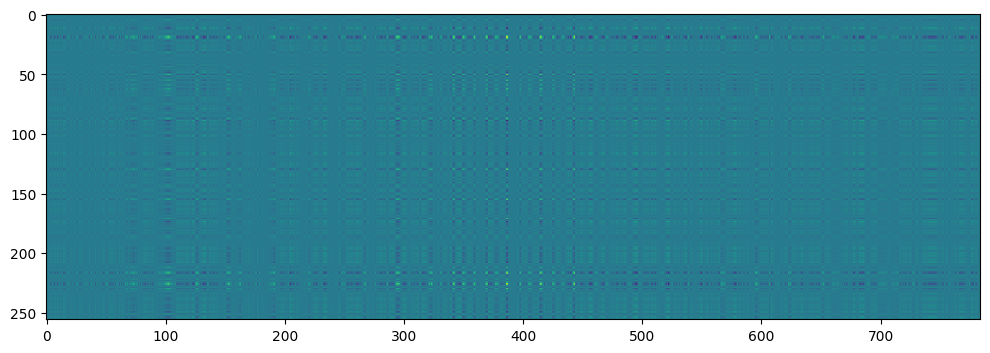

In [ ]:
Ai = model.layers[0].Ai
Bj = model.layers[0].Bj

AiBj = Ai.unsqueeze(-1) * Bj.unsqueeze(0)
print(AiBj.shape)
visualize_first_layer_weights(AiBj.T)
visualize_full_layer(AiBj.T)

## Training only wtith the hebbian learning rule

In [ ]:
# laod the model
if not train:
    model = HebbianNetworkClassifier(model_size, device=device, init="uni", dropout=0.1, bias=False, activation=torch.functional.F.relu)
    model.load_state_dict(torch.load("hebbian_mnist_neurocentric.pt"))
    model.reset_weights('linear')

    test_loss, test_accuracy, confusion_matrix = model.test(test_loader, loss_fn)
    print(f"Test accuracy: {test_accuracy}")
    print(f"Test loss: {test_loss}")

# plot the confusion matrix

Test: 100%|██████████| 20/20 [00:03<00:00,  5.68batch/s, Loss=1.23]                                            


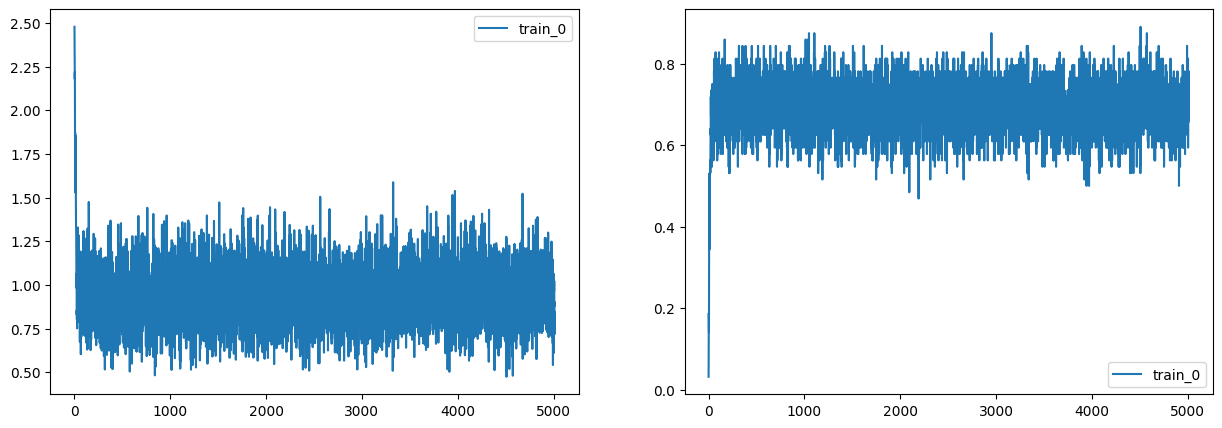

Test accuracy: 0.7068704044117646
Test loss: 0.00022622644901275634


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in range(10):
    train_loss, val_loss, test_loss, train_accuracy, val_accuracy, test_accuracy, confusion_matrix = model.hebbian_train_loop(
        loss_fn, trn_loader, None, test_loader, max_iter=5000, epochs=20, reset=True
    )
    ax[0].plot(train_loss, label=f"train_{i}")
    ax[1].plot(train_accuracy, label=f"train_{i}")
    break

ax[0].legend()
ax[1].legend()
plt.show()

# plot the results
#plot_val_train_loss(train_loss, val_loss, train_accuracy, val_accuracy)

#plot_val_train_loss(train_loss, val_loss, train_accuracy, val_accuracy)
# print_confusion_matrix(confusion_matrix)

# print the test results
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")


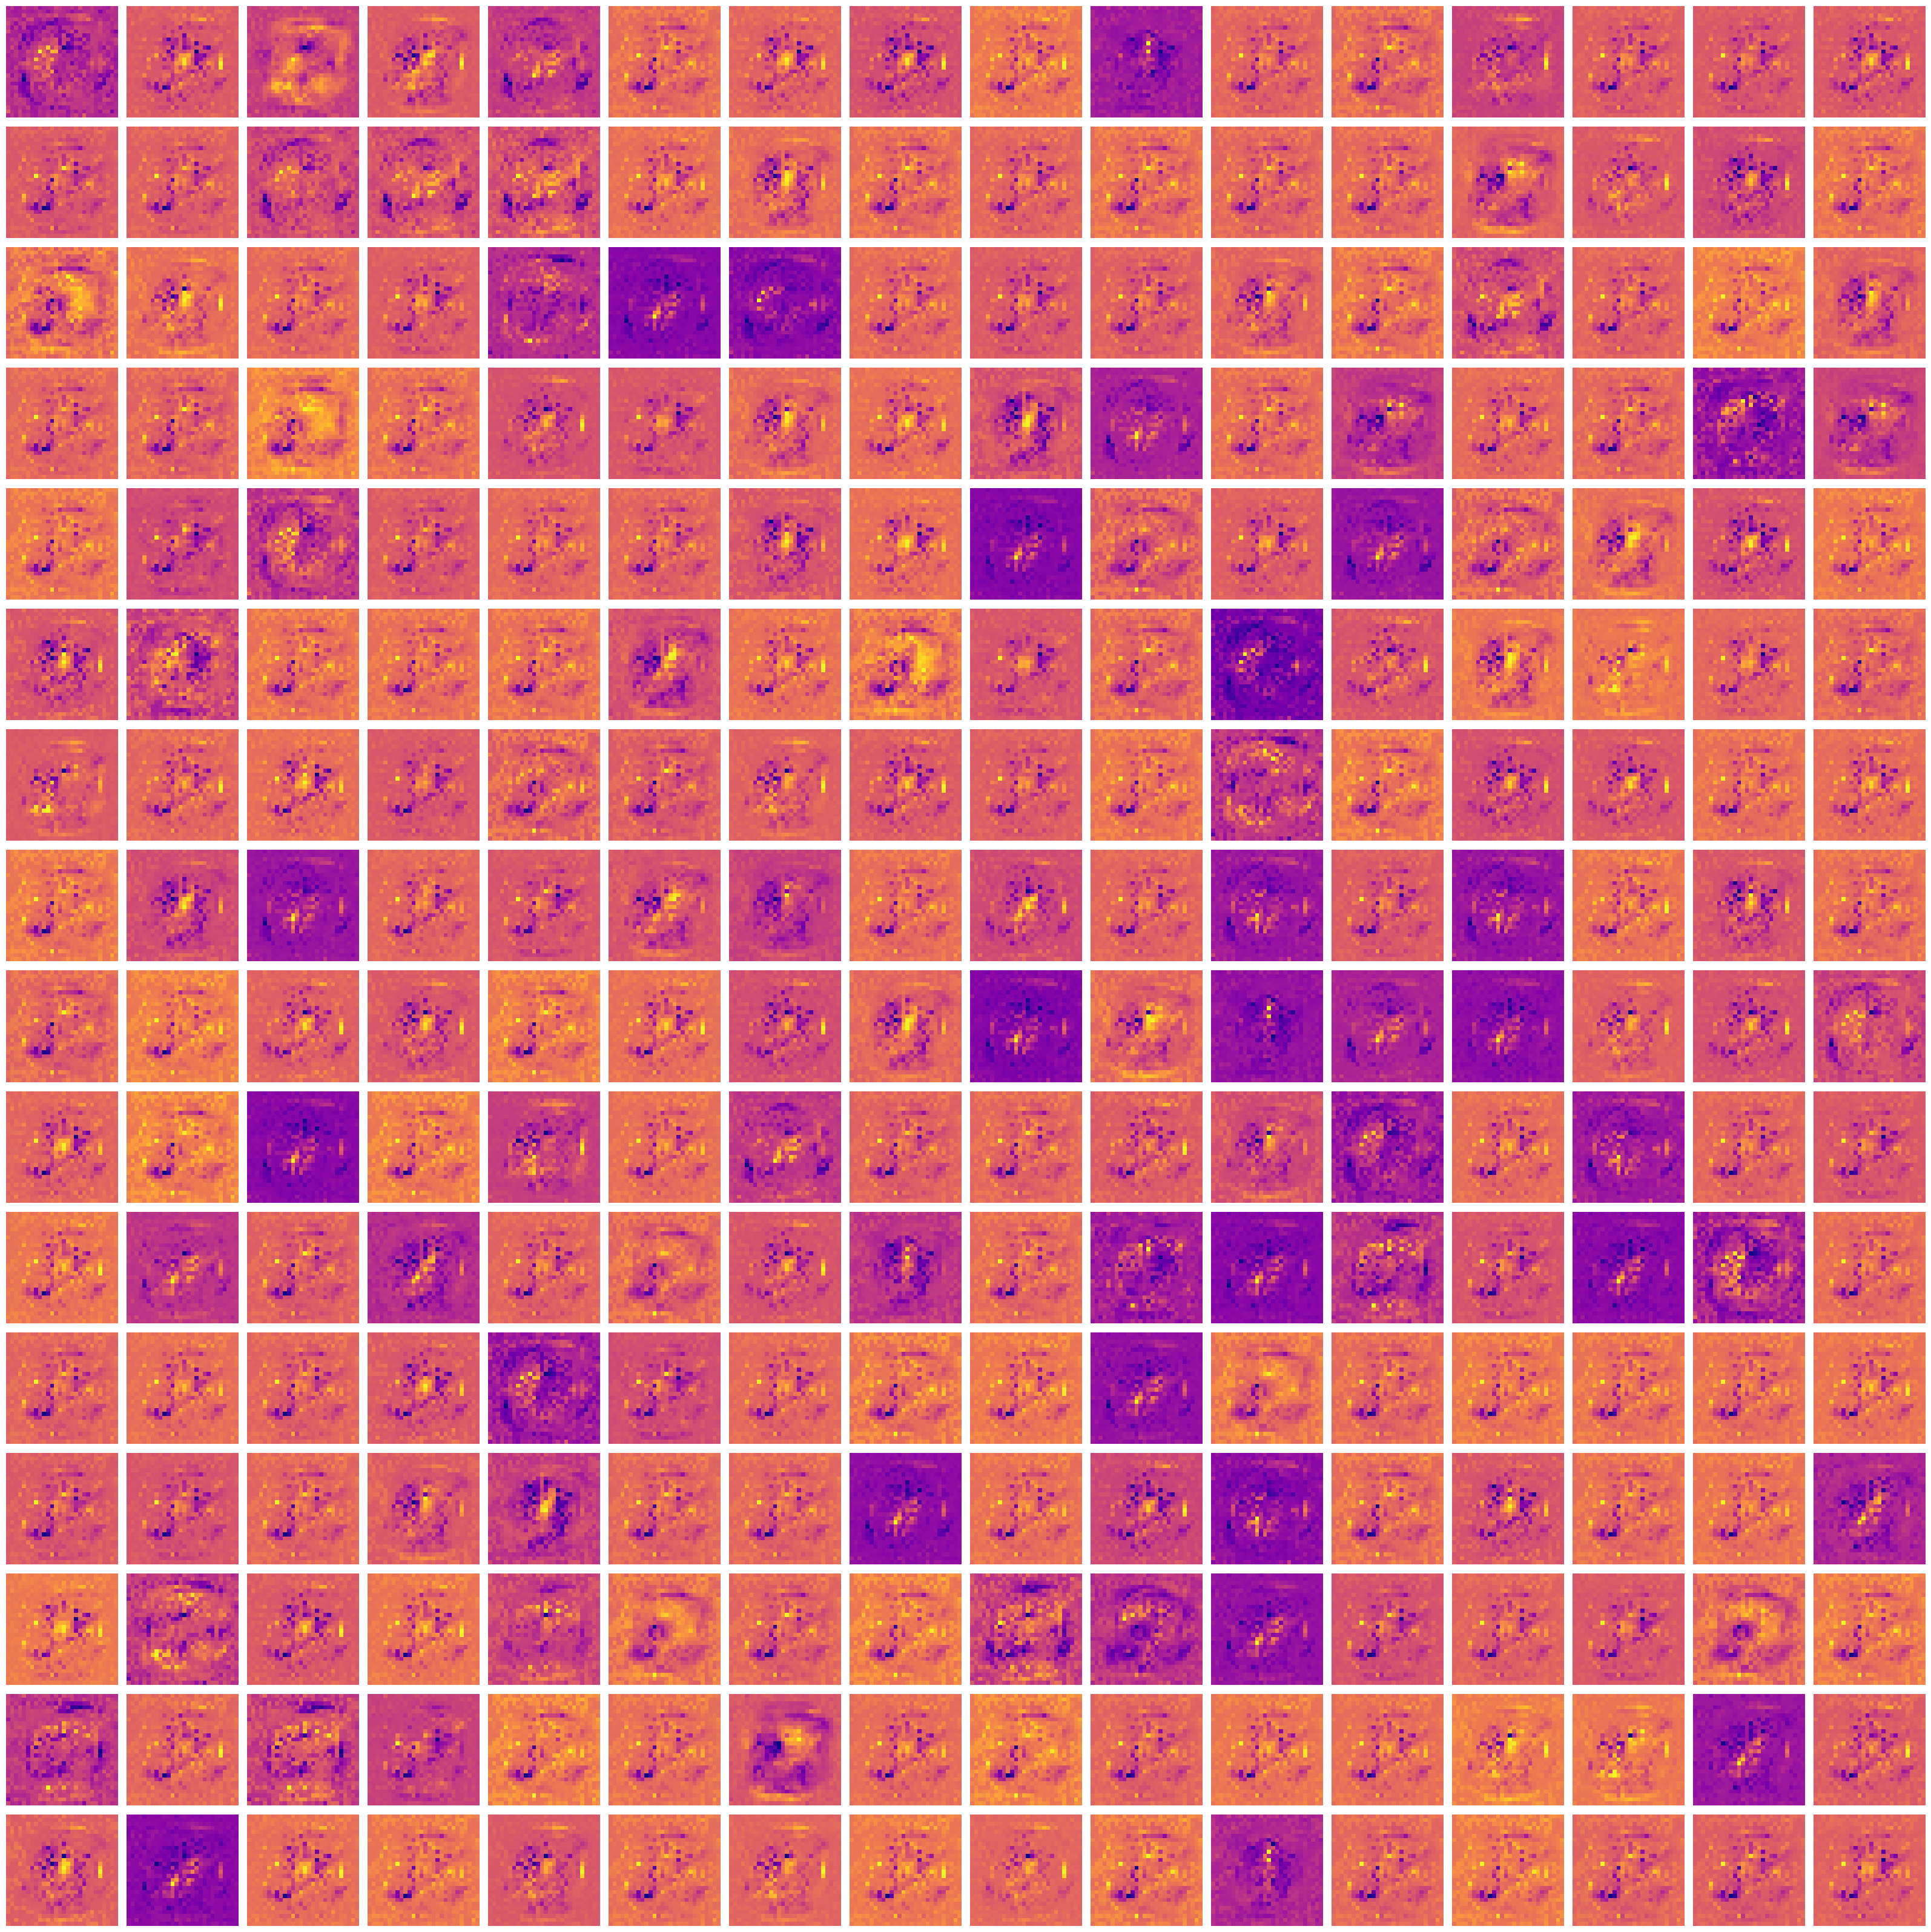

In [ ]:
visualize_first_layer_weights(model.layers[0].weight)


torch.Size([128, 784])


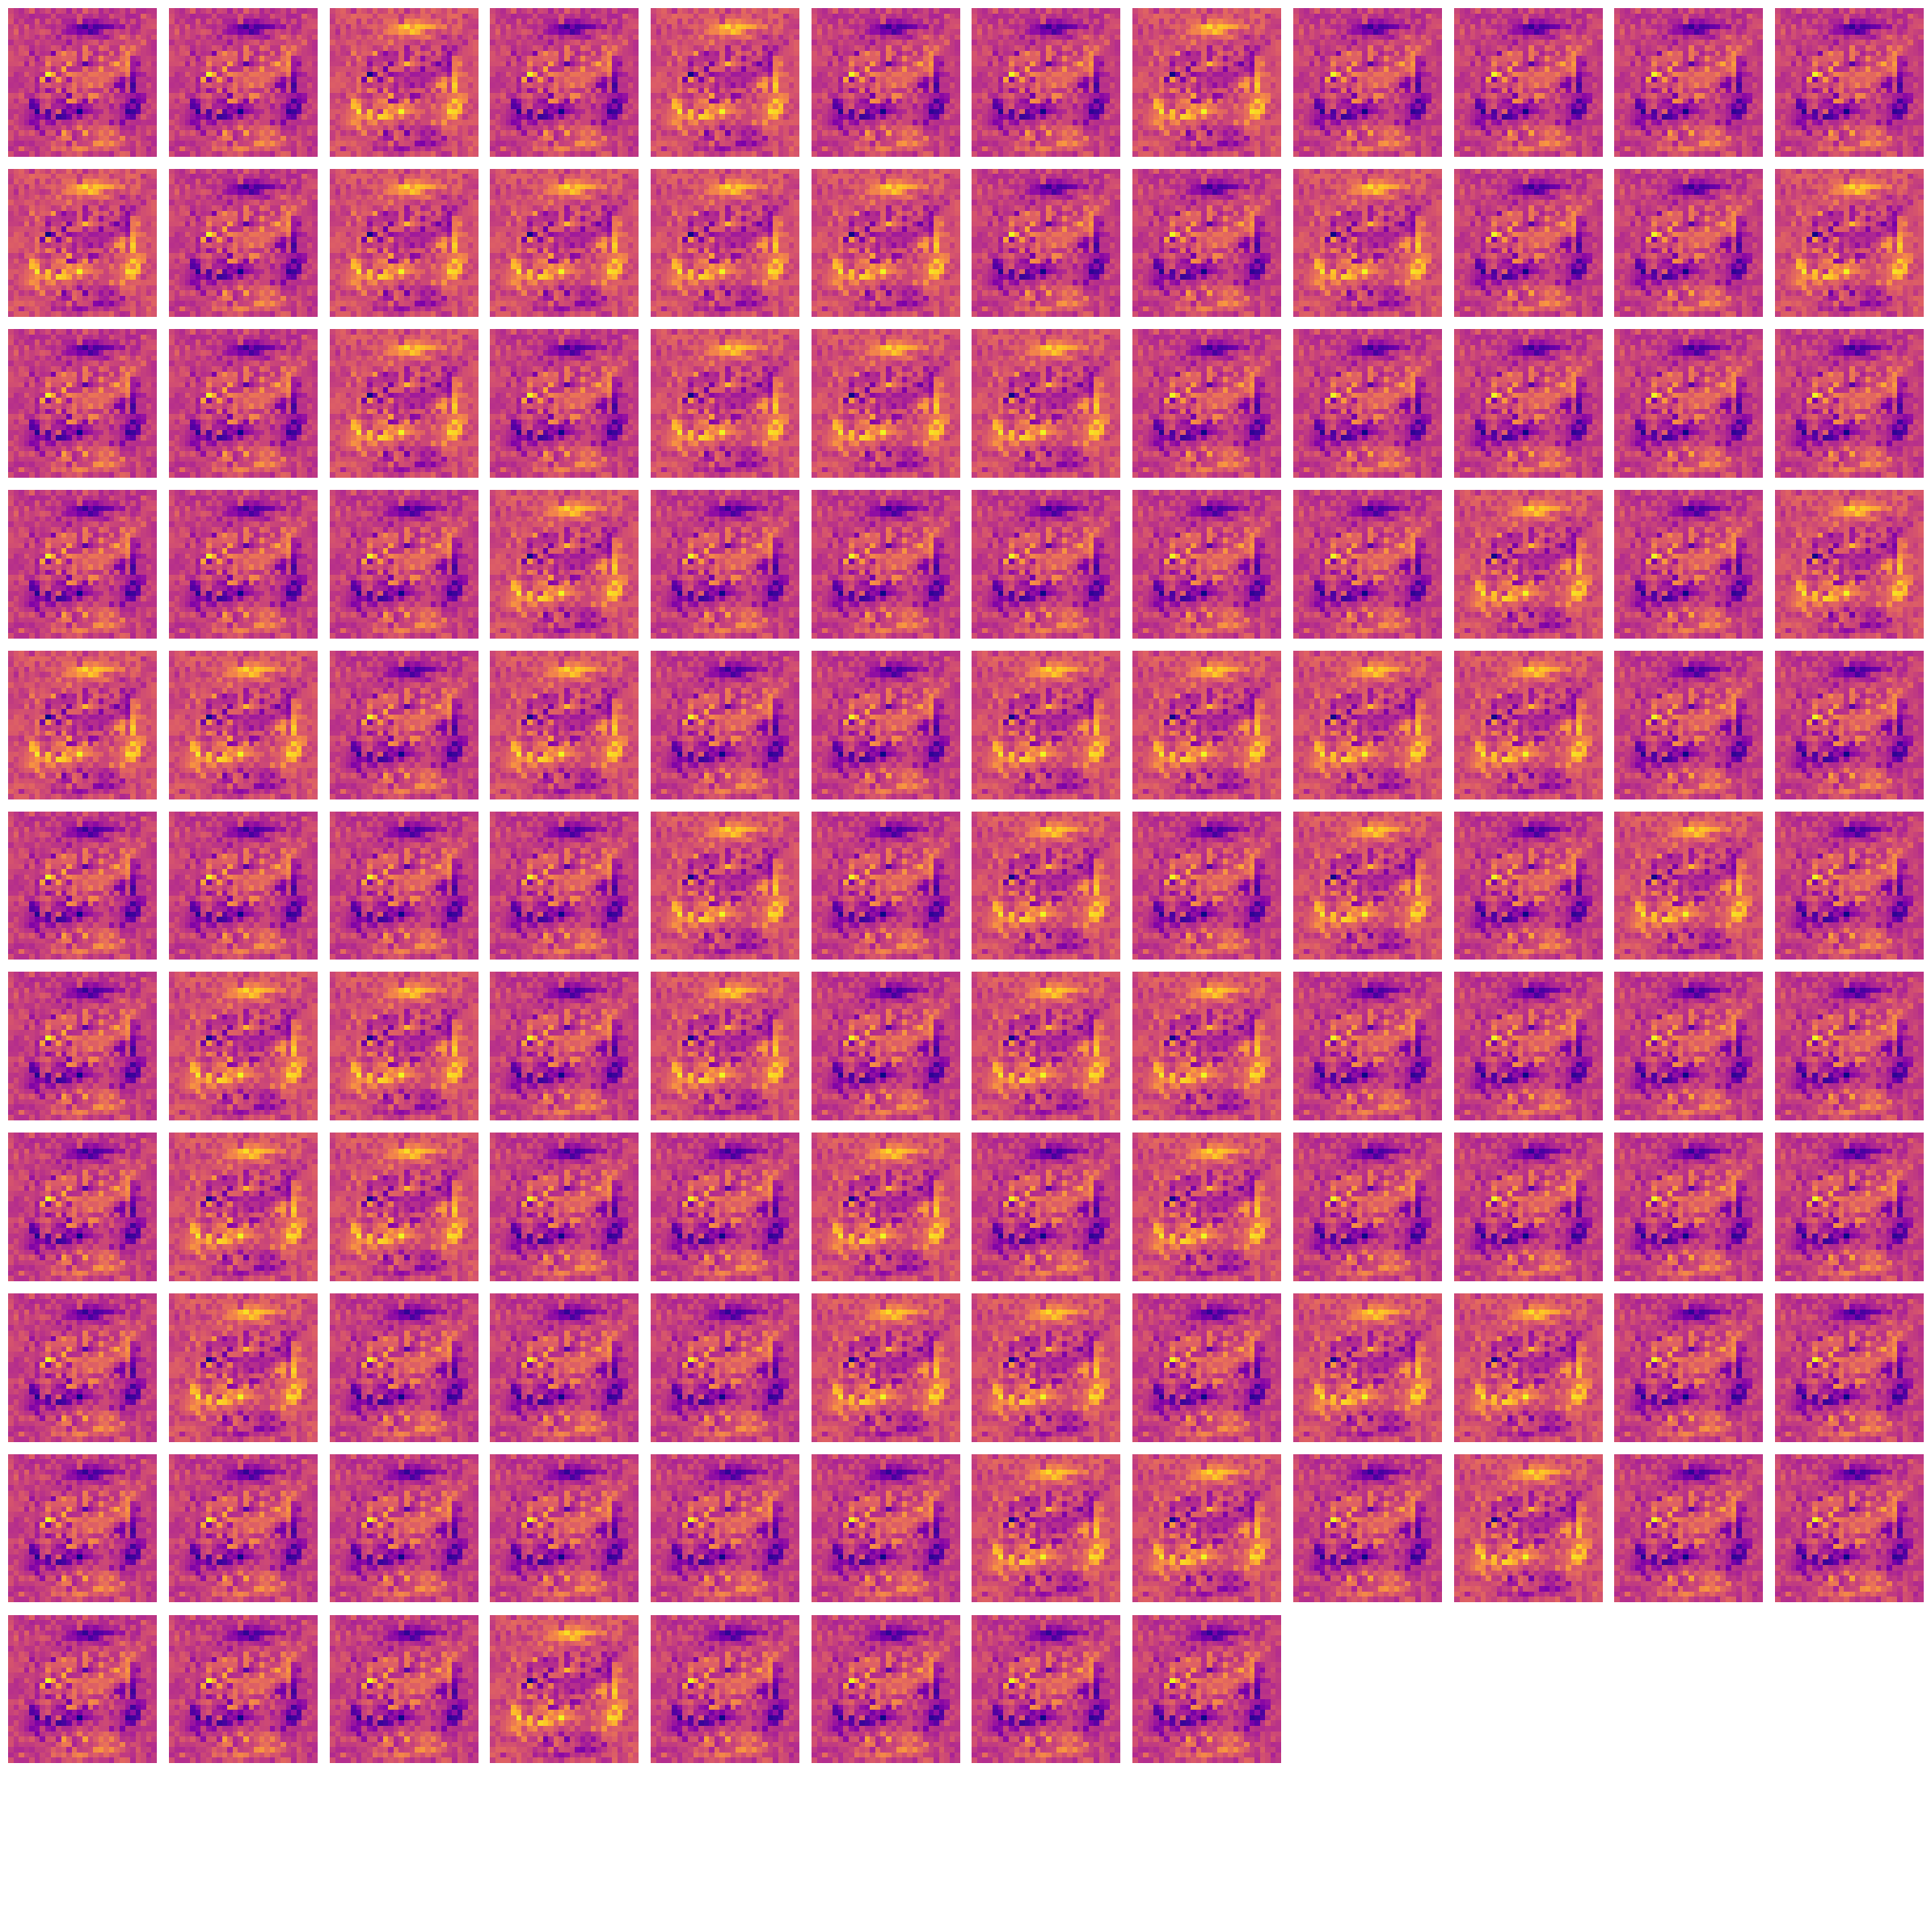

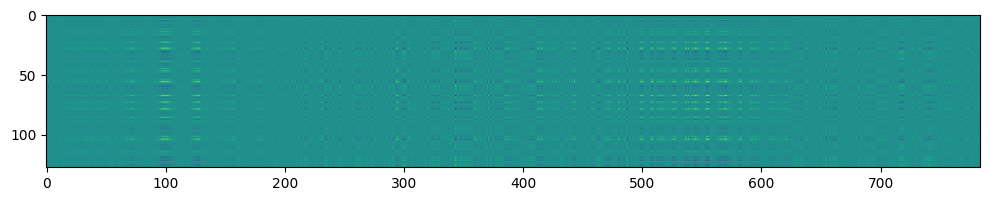

In [ ]:
eta = model.layers[0].Ei.unsqueeze(0) * model.layers[1].Ej.unsqueeze(-1)
print(eta.shape)
visualize_first_layer_weights(eta)
visualize_full_layer(eta)

# Training synaptic-centric model

## Training with backprop the hebbian rules

In [ ]:
model_synaptic = HebbianNetworkClassifier(
    model_size, 
    device=device, 
    dropout=0.1,
    activation=torch.functional.F.relu,
    neuron_centric=False
)

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model_synaptic.parameters(), lr=0.001, weight_decay=0.00)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

Test: 100%|██████████| 20/20 [00:03<00:00,  5.64batch/s, Loss=0.2]   


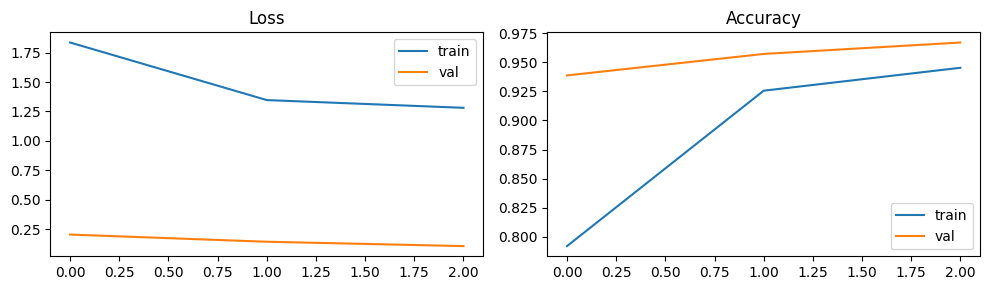

Test accuracy: 0.96904296875
Test loss: 3.6711051293155725e-05


In [ ]:
if train:
     # train the model with backprop
     train_loss, val_loss, test_loss, train_accuracy, val_accuracy, test_accuracy, confusion_matrix = model_synaptic.train_loop(
          optimizer, loss_fn, train_loader, val_loader, test_loader, epochs=3, log=False,
     )
     # save the model   
     torch.save(model_synaptic.state_dict(), "hebbian_mnist_synapticcenter.pt")

     plot_val_train_loss(train_loss, val_loss, train_accuracy, val_accuracy)

     # print the test results
     print(f"Test accuracy: {test_accuracy}")
     print(f"Test loss: {test_loss}")
     # print_confusion_matrix(confusion_matrix)

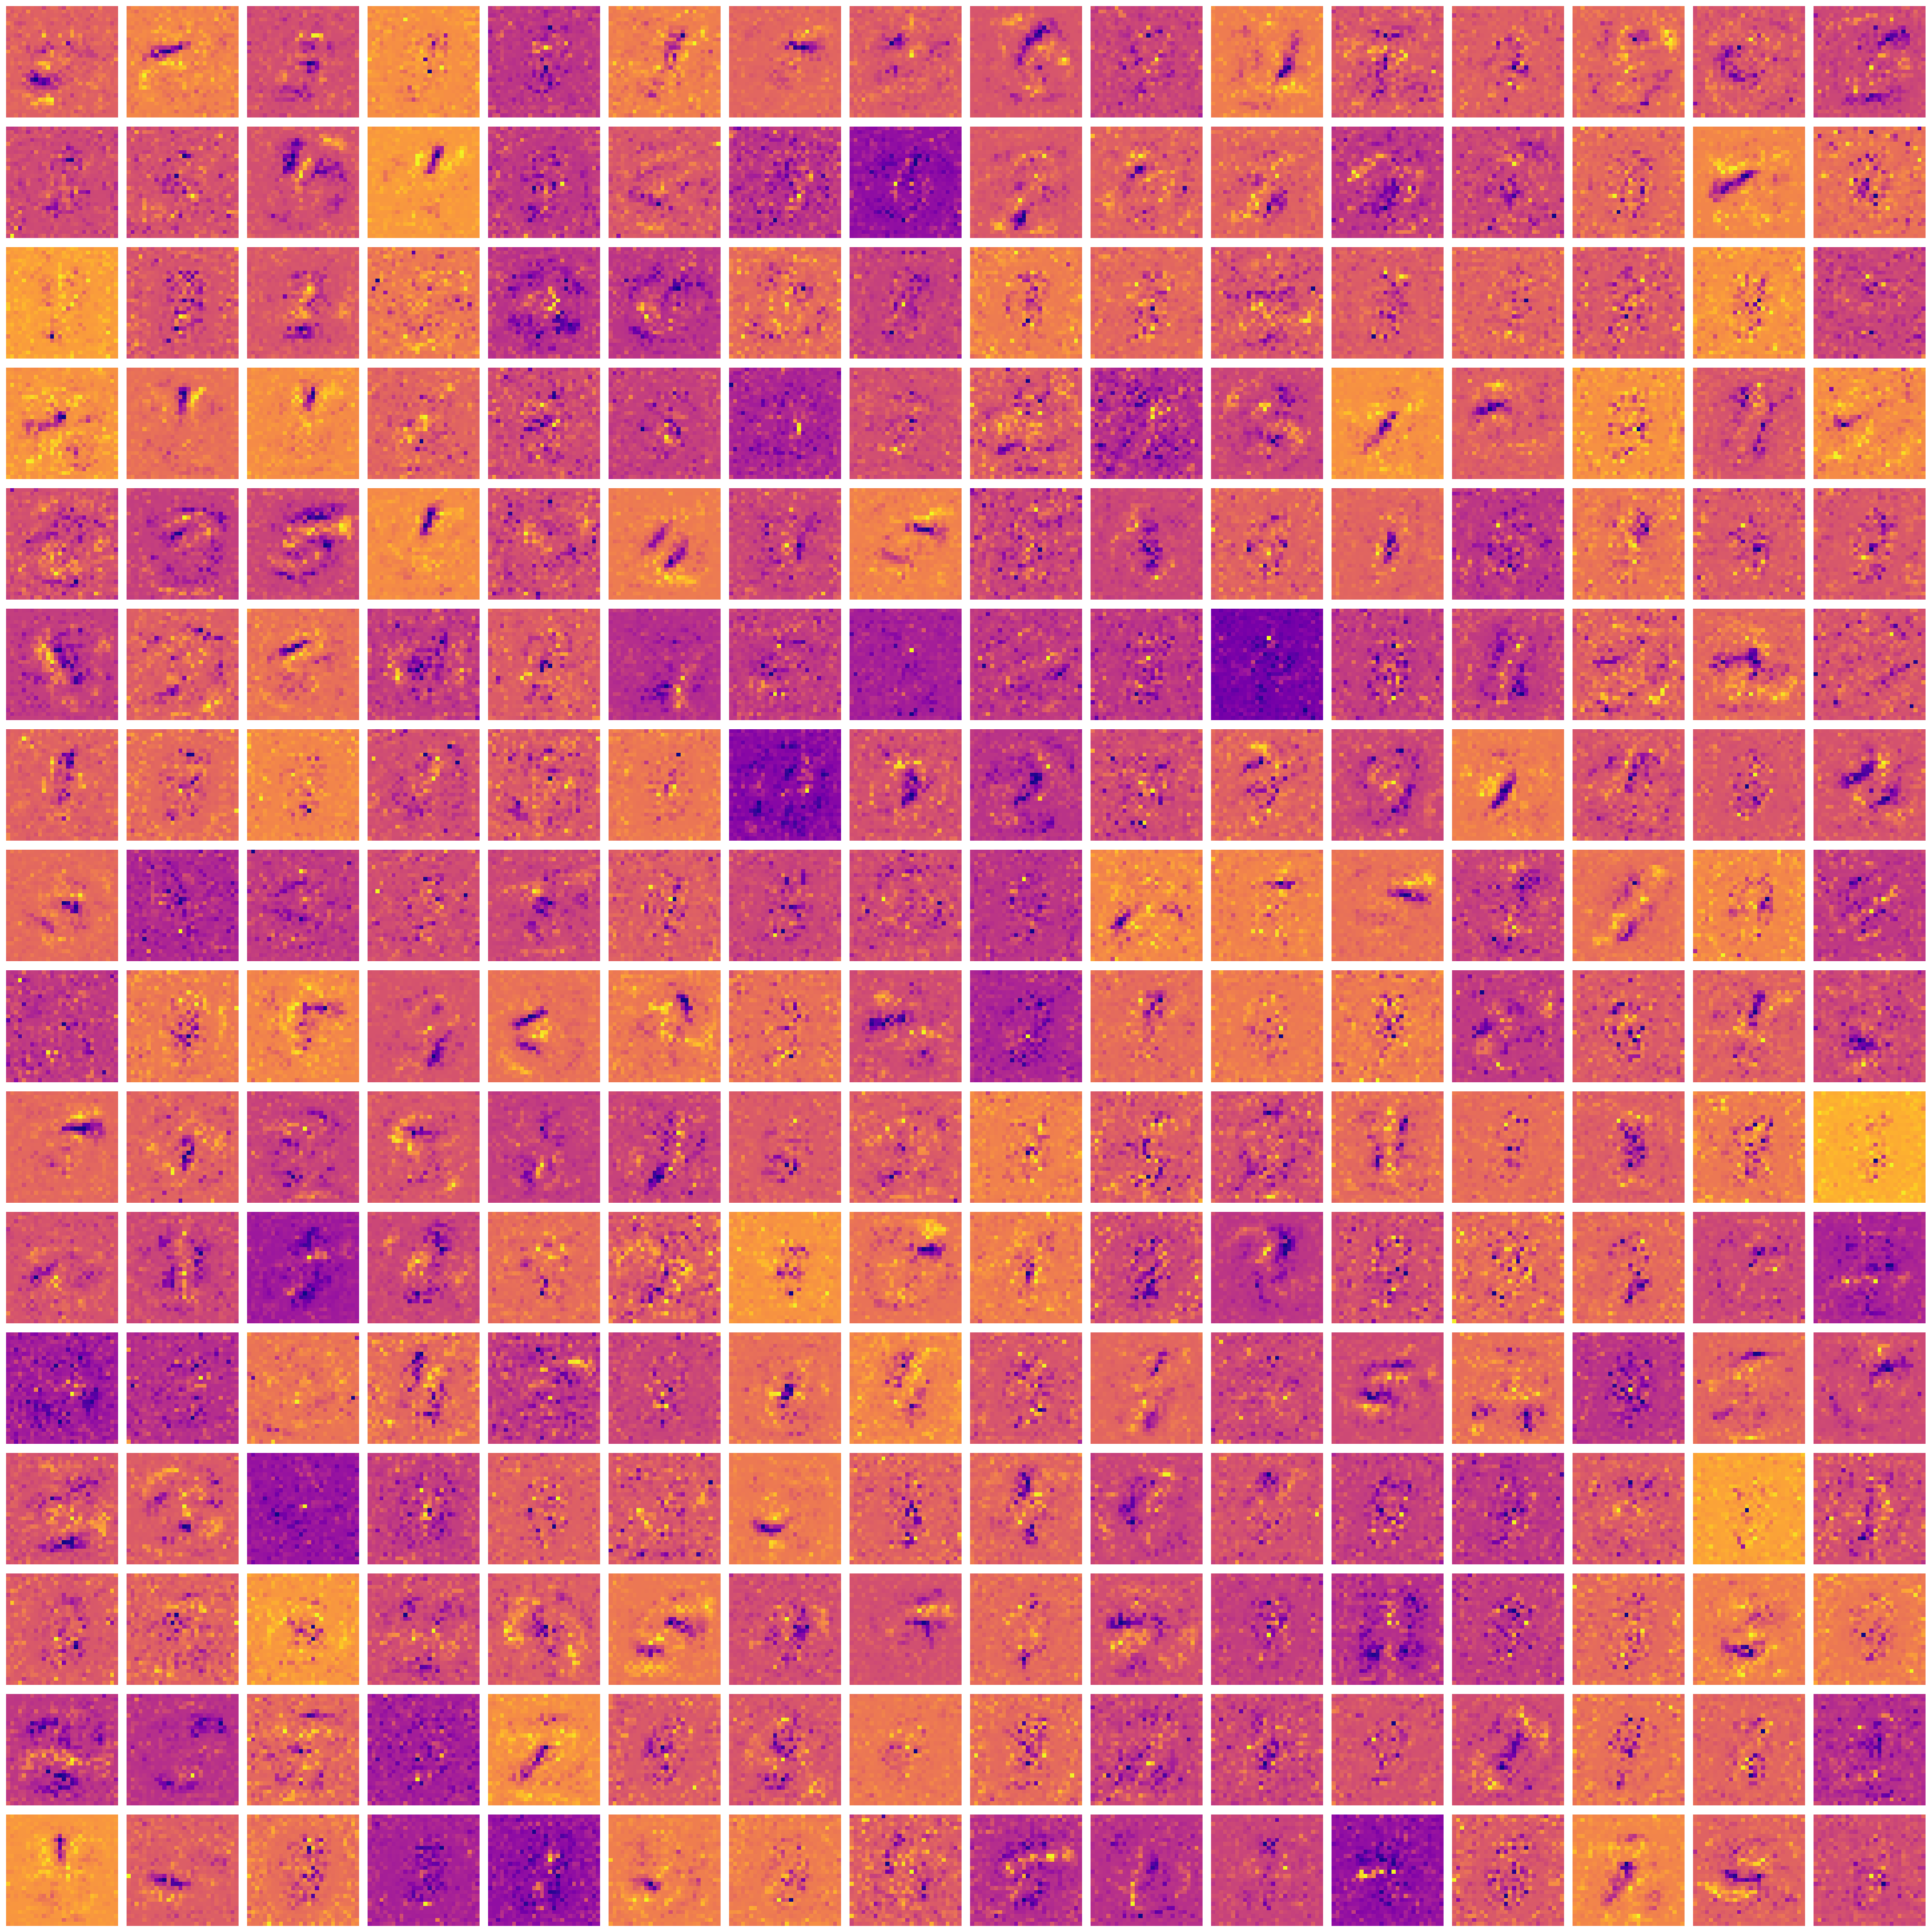

In [ ]:
visualize_first_layer_weights(model_synaptic.layers[0].weight)
# printACDE(model)

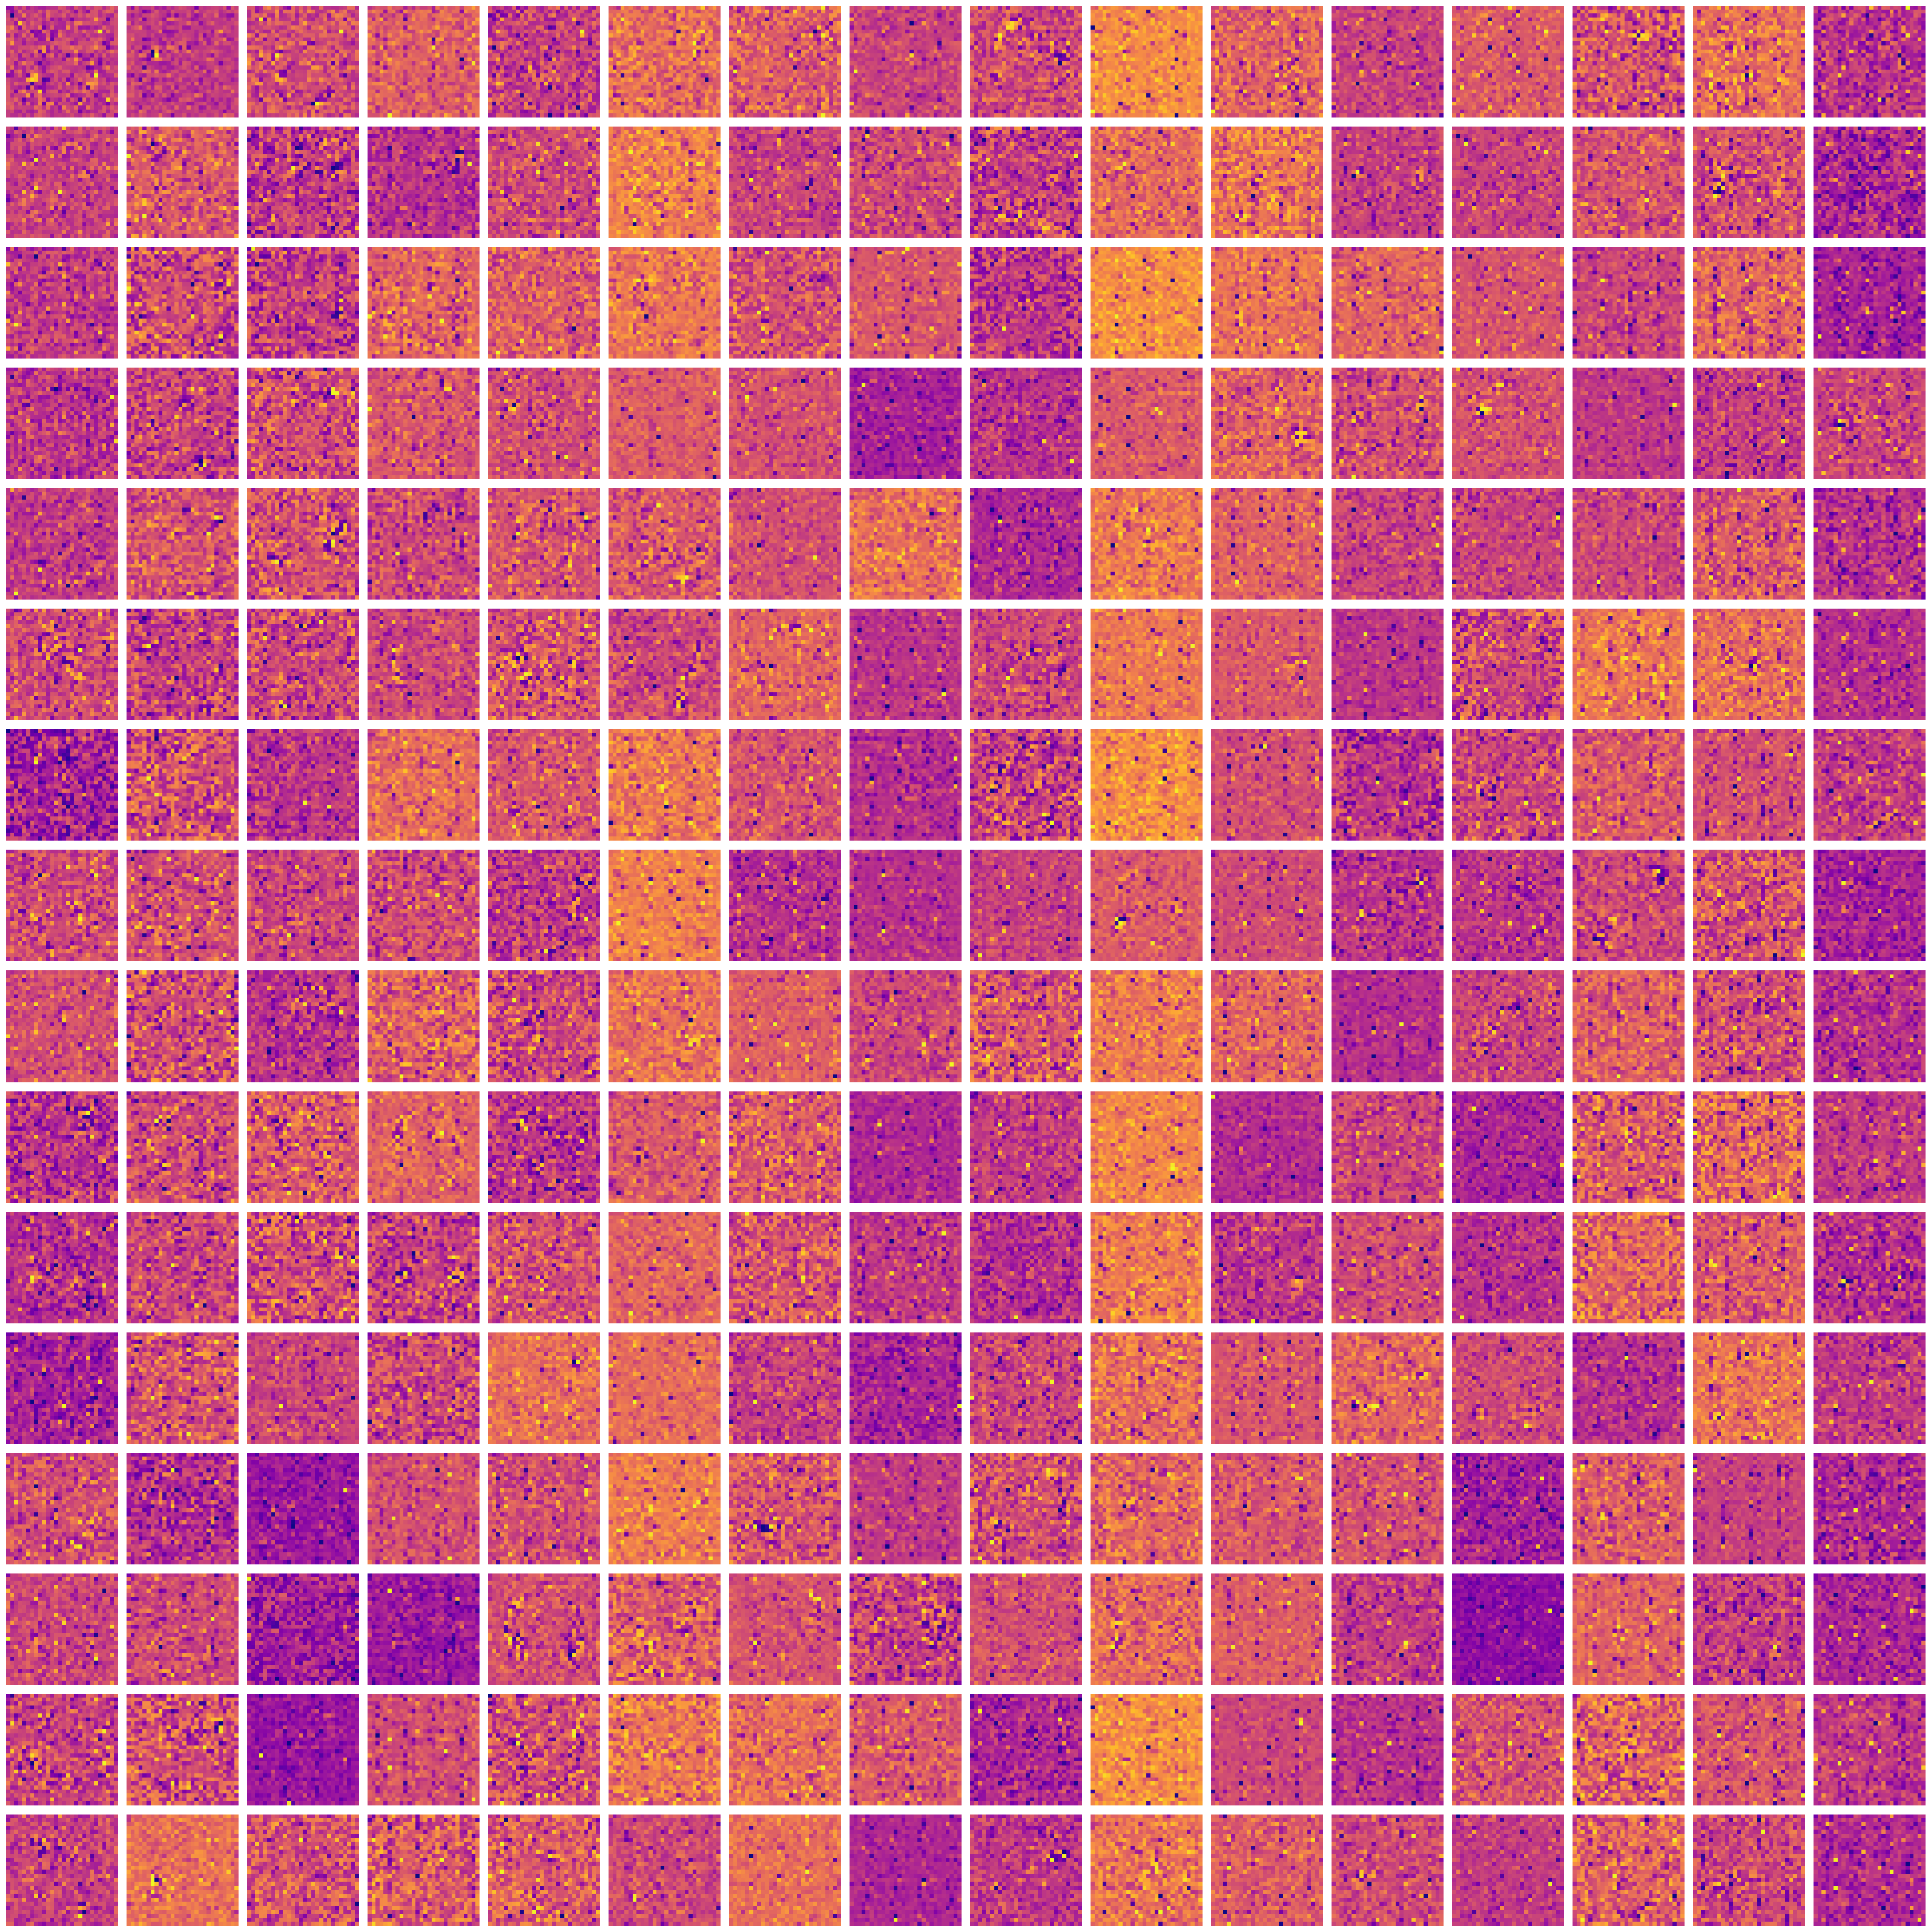

In [ ]:
visualize_first_layer_weights(model_synaptic.layers[0].C.T)

In [ ]:
visualize_first_layer_weights(model_synaptic.layers[0].A.T)

AttributeError: 'HebbianLinearLayer' object has no attribute 'A'

In [ ]:
visualize_full_layer(model_synaptic.layers[0].C.T)

## Training only wtith the hebbian learning rule

In [ ]:
# laod the model
if not train:
    model_synaptic = HebbianNetworkClassifier(model_size, device=device, init="uni", dropout=0.1, activation=torch.functional.F.relu)
    model_synaptic.load_state_dict(torch.load("hebbian_mnist_neurocentric.pt"))
    model_synaptic.reset_weights('linear')

    test_loss, test_accuracy, confusion_matrix = model_synaptic.test(test_loader, loss_fn)
    print(f"Test accuracy: {test_accuracy}")
    print(f"Test loss: {test_loss}")

In [ ]:
train_loss, val_loss, test_loss, train_accuracy, val_accuracy, test_accuracy, confusion_matrix = model_synaptic.hebbian_train_loop(
    loss_fn, val_loader, None, test_loader, max_iter=1000, epochs=2
)

# plot the results
plot_val_train_loss(train_loss, val_loss, train_accuracy, val_accuracy)

# print the test results
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")

plot_val_train_loss(train_loss, val_loss, train_accuracy, val_accuracy)

visualize_first_layer_weights(model_synaptic.layers[0].weight)
# printACDE(model_synaptic)

# Training with classical backpropagation

In [ ]:
# normal backpropagation

import torch.nn as nn

backprop_model = nn.Sequential(
    nn.Linear(784, 16, bias=False),
    nn.ReLU(),
    nn.Linear(16, 10, bias=False)
).to(device)

loss_fn = torch.nn.CrossEntropyLoss()

backprop_optimizer = torch.optim.AdamW(backprop_model.parameters(), lr=0.001, weight_decay=0.0)

num_epochs = 3
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_correct = 0
    for images, labels in train_loader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = backprop_model(images)
        loss = loss_fn(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        backprop_optimizer.step()
        backprop_optimizer.zero_grad()
        
        # Track training loss and accuracy
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = backprop_model(images)
            loss = loss_fn(outputs, labels)
            
            # Track validation loss and accuracy
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
    
    # Calculate average losses and accuracies
    train_loss /= len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)
    val_loss /= len(val_dataset)
    val_accuracy = val_correct / len(val_dataset)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Final test
model.eval()
test_loss = 0.0
test_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = backprop_model(images)
        loss = loss_fn(outputs, labels)
        
        # Track test loss and accuracy
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()

# Calculate average test loss and accuracy
test_loss /= len(test_dataset)
test_accuracy = test_correct / len(test_dataset)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch [1/3], Train Loss: 0.4443, Train Accuracy: 0.8688, Val Loss: 0.2589, Val Accuracy: 0.9244


KeyboardInterrupt: 

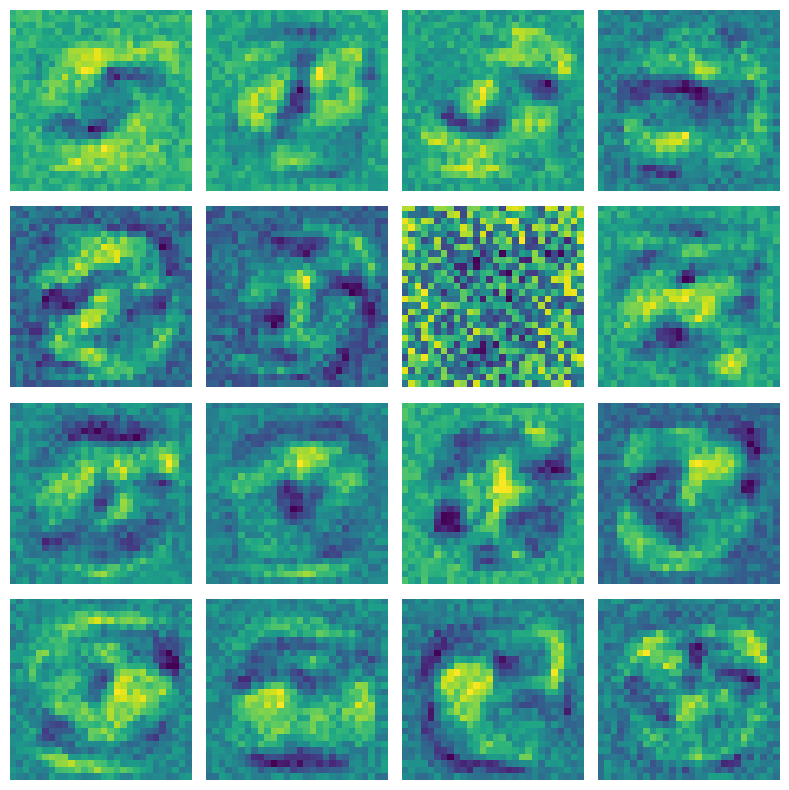

In [ ]:
visualize_first_layer_weights(backprop_model[0].weight)

0: var: 0.03983376547694206, dft: 477.5230712890625, min: -0.2405797392129898, max: 0.1258438527584076
1: var: 0.039918988943099976, dft: 505.8099365234375, min: -0.22166576981544495, max: 0.16012762486934662
2: var: 0.037232425063848495, dft: 461.5005187988281, min: -0.2019815891981125, max: 0.13229408860206604
3: var: 0.03418707102537155, dft: 429.26409912109375, min: -0.14964258670806885, max: 0.14019495248794556
4: var: 0.041680458933115005, dft: 471.2436218261719, min: -0.13764502108097076, max: 0.13481992483139038
5: var: 0.03287861496210098, dft: 465.2630615234375, min: -0.1364731341600418, max: 0.1519206464290619
6: var: 0.009991058148443699, dft: 378.3244934082031, min: -0.044985219836235046, max: 0.04655604064464569
7: var: 0.04074056074023247, dft: 479.29913330078125, min: -0.19186504185199738, max: 0.14609383046627045
8: var: 0.04367285966873169, dft: 461.3170166015625, min: -0.17142149806022644, max: 0.1632535755634308
9: var: 0.040142714977264404, dft: 432.9796142578125, 

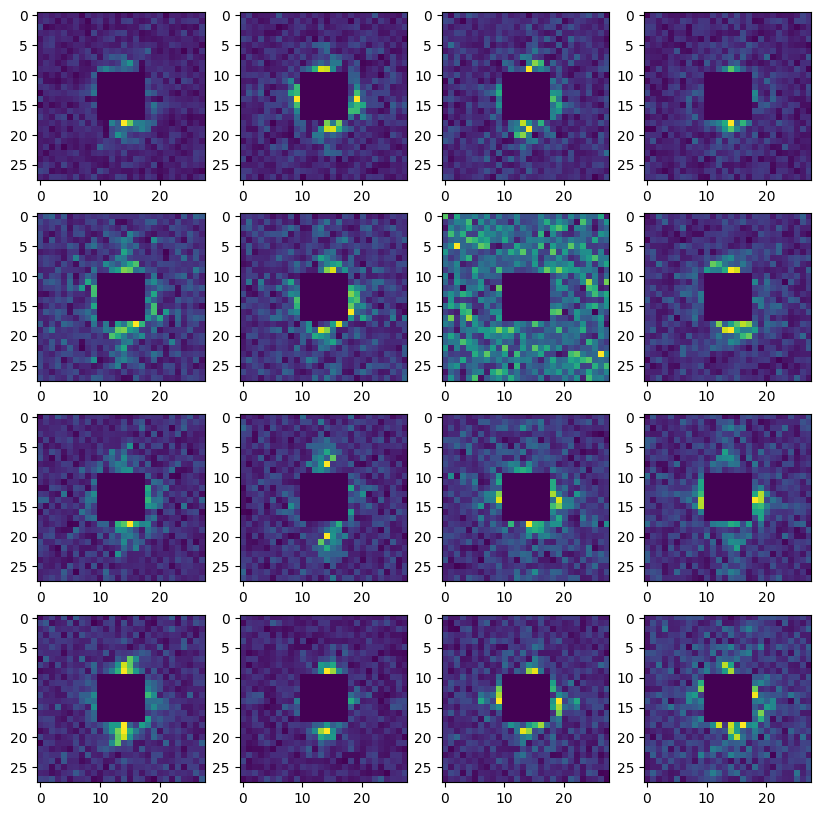

In [ ]:
# calculate the variance of the blurred version of every neuron:
import torchvision
gaussan_filter = torchvision.transforms.GaussianBlur(3, sigma=(1, 1))
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i, w in enumerate(backprop_model[0].weight):
    # reshape the weights to 28x28
    w = w.view(28, 28).clone().detach().cpu()
    blurr = gaussan_filter(w.unsqueeze(0))
    dft = torch.fft.fftshift(torch.fft.fft2(w))
    # zero out the low frequencies
    dft[10:18, 10:18] = 0
    magnitude = torch.abs(dft)
    # apply the gaussian filter
    # w = gaussan_filter(w.unsqueeze(0))
    print(f'{i}: var: {blurr.std()}, dft: {magnitude.sum()}, min: {w.min()}, max: {w.max()}')
    ax[i // 4, i % 4].imshow(magnitude, cmap='viridis')


In [ ]:
print(f"Rank of first layer: {np.linalg.matrix_rank(backprop_model[0].weight.detach().cpu().numpy())}")
print("Shape of first layer weights: ", backprop_model[0].weight.shape)
print(f"Rank of second layer: {np.linalg.matrix_rank(backprop_model[3].weight.detach().cpu().numpy())}")
print("Shape of second layer weights: ", backprop_model[3].weight.shape)
print(f"Rank of third layer: {np.linalg.matrix_rank(backprop_model[6].weight.detach().cpu().numpy())}")
print("Shape of third layer weights: ", backprop_model[6].weight.shape)

- ABCD rule necessaria?
- training layer by layer with specific loss
- first loss